In [2]:
!pip install bert_score --quiet

ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [3]:
!pip install transformers

  Using cached transformers-4.40.1-py3-none-any.whl (9.0 MB)
  Using cached safetensors-0.4.3-cp39-none-win_amd64.whl (287 kB)
  Using cached huggingface_hub-0.23.0-py3-none-any.whl (401 kB)
  Using cached tokenizers-0.19.1-cp39-none-win_amd64.whl (2.2 MB)
  Using cached fsspec-2024.3.1-py3-none-any.whl (171 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.7.1
    Uninstalling fsspec-2022.7.1:
      Successfully uninstalled fsspec-2022.7.1


In [4]:
!pip install sentencepiece

     -------------------------------------- 991.5/991.5 kB 1.6 MB/s eta 0:00:00


In [14]:
!pip install inflect

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import random
import string
import inflect
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
#from bert_score import BERTScorer
from rouge import Rouge
from transformers import BartForConditionalGeneration, BartTokenizer
import warnings
import pickle

In [2]:
warnings.filterwarnings("ignore")

In [3]:
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [12]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to C:\Users\Ansh
[nltk_data]     Lulla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ansh
[nltk_data]     Lulla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Ansh
[nltk_data]     Lulla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Ansh
[nltk_data]     Lulla\AppData\Roaming\nltk_data...


True

In [13]:
def lowercase_text(text):
    return text.lower()

def tokenize_text(text):
    return word_tokenize(text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

p = inflect.engine()
def convert_number(text):
    temp_str = text.split()
    new_string = []

    for word in temp_str:
        if word.isdigit():
            temp = p.number_to_words(word)
            new_string.append(temp)
        else:
            new_string.append(word)

    temp_str = ' '.join(new_string)
    return temp_str

def convert_numbers_in_text(text):
    return convert_number(text)

def preprocess_text(text):
    # Example: Apply the preprocessing functions
    text = lowercase_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text= lemmatize_text(text)
    text = convert_number(text)
    text = convert_numbers_in_text(text)
    return text

# Define the function to access and preprocess text and summary
def access_and_preprocess_text(doc_file_path, summary_file_path):
    with open(doc_file_path, 'r', encoding='utf-8') as doc_file:
        doc_text = doc_file.read()
        processed_doc_text = preprocess_text(doc_text)

    with open(summary_file_path, 'r', encoding='utf-8') as summary_file:
        summary_text = summary_file.read()
        processed_summary_text = preprocess_text(summary_text)

    return processed_doc_text, processed_summary_text

In [14]:
# Initialize empty lists for training documents (X_train) and summaries (y_train)
X_train = []
y_train = []

# Initialize empty lists for testing documents (X_test) and summaries (y_test)
X_test = []
y_test = []

In [15]:
# Directories for training and testing documents and summaries
train_doc_folder = r"C:\Users\Ansh Lulla\PycharmProjects\SML_Project\dataset\IN-Abs\train-data\judgement"
train_summary_folder = r"C:\Users\Ansh Lulla\PycharmProjects\SML_Project\dataset\IN-Abs\train-data\summary"
test_doc_folder = r"C:\Users\Ansh Lulla\PycharmProjects\SML_Project\dataset\IN-Abs\test-data\judgement"
test_summary_folder = r"C:\Users\Ansh Lulla\PycharmProjects\SML_Project\dataset\IN-Abs\test-data\summary"

In [16]:
# Specify the number of training and testing documents to process
num_train_documents = 1000
num_test_documents = 100

In [17]:
# Get list of training and testing document files
train_doc_files = os.listdir(train_doc_folder)
train_summary_files = os.listdir(train_summary_folder)
test_doc_files = os.listdir(test_doc_folder)
test_summary_files = os.listdir(test_summary_folder)

In [18]:
# Process the specified number of training documents and collect X_train and y_train
for i in range(num_train_documents):
    doc_file = train_doc_files[i]
    summary_file = train_summary_files[i]
    processed_doc_text, processed_summary_text = access_and_preprocess_text(os.path.join(train_doc_folder, doc_file),
                                                                            os.path.join(train_summary_folder, summary_file))
    X_train.append(processed_doc_text)
    y_train.append(processed_summary_text)

In [19]:
# Process the specified number of testing documents and collect X_test and y_test
for i in range(num_test_documents):
    doc_file = test_doc_files[i]
    summary_file = test_summary_files[i]
    processed_doc_text, processed_summary_text = access_and_preprocess_text(os.path.join(test_doc_folder, doc_file),
                                                                            os.path.join(test_summary_folder, summary_file))
    X_test.append(processed_doc_text)
    y_test.append(processed_summary_text)

In [20]:
# Setting up validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [21]:
print(f"Total Training Documents: {len(X_train)}")
print(f"Total Validation Documents: {len(X_val)}")
print(f"Total Testing Documents: {len(X_test)}")
print(f"Total Training Summaries: {len(y_train)}")
print(f"Total Validation Summaries: {len(y_val)}")
print(f"Total Testing Summaries: {len(y_test)}")

Total Training Documents: 750
Total Validation Documents: 250
Total Testing Documents: 100
Total Training Summaries: 750
Total Validation Summaries: 250
Total Testing Summaries: 100


In [22]:
# Define the TF-IDF vectorizer with updated parameters
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))

# Vectorize the training, validation, and testing data
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

y_train_tfidf = tfidf.fit_transform(y_train)
y_val_tfidf = tfidf.transform(y_val)
y_test_tfidf = tfidf.transform(y_test)

In [23]:
# Initialize SVC model with default hyperparameters
svc_model = SVC()

# Fit the model on the TF-IDF transformed training data
svc_model.fit(X_train_tfidf, y_train)

SVC()

In [24]:
# Make predictions on the validation data
y_pred_val_svc = svc_model.predict(X_val_tfidf)

In [25]:
print(cosine_similarity(tfidf.transform(y_val), tfidf.transform(y_pred_val_svc)).mean())

0.061309112291229644


In [67]:
# BERTScorer leverages the pre-trained contextual embeddings from BERT and matches words in candidate and reference sentences by cosine similarity

# Instantiate the BERTScorer object for English language
scorer = BERTScorer(lang="en")

# Initialize lists to store F1 scores for each summary
summary_svc_f1_scores = []

# Iterate through each pair of summaries and excerpts in the validation data
for summary_svc, excerpt in zip(y_pred_val_svc, y_val):
    # Calculate BERTScore for summary against the excerpt
    P_svc, R_svc, F1_svc = scorer.score([excerpt], [summary_svc])
    summary_svc_f1_scores.append(F1_svc.tolist()[0])

# Calculate the average F1 score for each summary across the entire validation dataset
avg_summary_svc_f1_score = sum(summary_svc_f1_scores) / len(summary_svc_f1_scores)

print("Average Support Vector Machine F1 Score:", avg_summary_svc_f1_score)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average Support Vector Machine F1 Score: 0.820165152311325


In [26]:
# Initialize Multinomial Naive Bayes model
nb_model = MultinomialNB(alpha=0.7, fit_prior=False)

# Fit the model on the TF-IDF transformed training data
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=0.7, fit_prior=False)

In [27]:
# Make predictions on the validation data
y_pred_val_nb = nb_model.predict(X_val_tfidf)

In [28]:
print(cosine_similarity(tfidf.transform(y_val), tfidf.transform(y_pred_val_nb)).mean())

0.05950984607778908


In [62]:
# Instantiate the BERTScorer object for English language
scorer = BERTScorer(lang="en")

# Initialize lists to store F1 scores for each summary
summary_nb_f1_scores = []

# Iterate through each pair of summaries and excerpts in the validation data
for summary_nb, excerpt in zip(y_pred_val_nb, y_val):
    # Calculate BERTScore for summary against the excerpt
    P_nb, R_nb, F1_nb = scorer.score([excerpt], [summary_nb])
    summary_nb_f1_scores.append(F1_nb.tolist()[0])

# Calculate the average F1 score for each summary across the entire validation dataset
avg_summary_nb_f1_score = sum(summary_nb_f1_scores) / len(summary_nb_f1_scores)

print("Average Naive Bayes F1 Score:", avg_summary_nb_f1_score)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average Naive Bayes F1 Score: 0.8215642130374908


In [29]:
# Intitialize Random Forest Classifier
rfc_model = RandomForestClassifier(n_estimators=100)

# Fit the model on the TF-IDF transformed training data
rfc_model.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [30]:
# Make predictions on the validation data
y_pred_val_rfc = rfc_model.predict(X_val_tfidf)

In [31]:
print(cosine_similarity(tfidf.transform(y_val), tfidf.transform(y_pred_val_rfc)).mean())

0.0576617658628743


In [63]:
# Instantiate the BERTScorer object for English language
scorer = BERTScorer(lang="en")

# Initialize lists to store F1 scores for each summary
summary_rfc_f1_scores = []

# Iterate through each pair of summaries and excerpts in the validation data
for summary_rfc, excerpt in zip(y_pred_val_rfc, y_val):
    # Calculate BERTScore for summary against the excerpt
    P_rfc, R_rfc, F1_rfc = scorer.score([excerpt], [summary_rfc])
    summary_rfc_f1_scores.append(F1_rfc.tolist()[0])

# Calculate the average F1 score for each summary across the entire validation dataset
avg_summary_rfc_f1_score = sum(summary_rfc_f1_scores) / len(summary_rfc_f1_scores)

print("Average Random Forest F1 Score:", avg_summary_rfc_f1_score)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average Random Forest F1 Score: 0.8167779064178466


In [33]:
# Best Model Performance so far -> Naive Bayes
# Applying AdaBoost on Naive Bayes
adaboost = AdaBoostClassifier(n_estimators=5,
                              #estimator=nb_model,
                              learning_rate=0.01)

nb_model_boost = adaboost.fit(X_train_tfidf, y_train)

In [34]:
y_pred_val_nb_boost = nb_model_boost.predict(X_val_tfidf)

In [35]:
print(cosine_similarity(tfidf.transform(y_val), tfidf.transform(y_pred_val_nb_boost)).mean())

0.09111562843844907


In [64]:
# Instantiate the BERTScorer object for English language
scorer = BERTScorer(lang="en")

# Initialize lists to store F1 scores for each summary
summary_nb_boost_f1_scores = []

# Iterate through each pair of summaries and excerpts in the validation data
for summary_nb_boost, excerpt in zip(y_pred_val_nb_boost, y_val):
    # Calculate BERTScore for summary against the excerpt
    P_nb_boost, R_nb_boost, F1_nb_boost = scorer.score([excerpt], [summary_nb_boost])
    summary_nb_boost_f1_scores.append(F1_nb_boost.tolist()[0])

# Calculate the average F1 score for each summary across the entire validation dataset
avg_summary_nb_boost_f1_score = sum(summary_nb_boost_f1_scores) / len(summary_nb_boost_f1_scores)

print("Average Naive Bayes with AdaBoost F1 Score:", avg_summary_nb_boost_f1_score)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average Naive Bayes with AdaBoost F1 Score: 0.8193436319828034


In [36]:
# Voting Classifier
estimators = []
estimators.append(("svc", svc_model))
estimators.append(("nb", nb_model))
estimators.append(("rfc", rfc_model))

In [37]:
vot_soft = VotingClassifier(estimators = estimators, voting ='hard', verbose=True)

In [38]:
vot_soft.fit(X_train_tfidf,y_train)

[Voting] ...................... (1 of 3) Processing svc, total=   6.6s
[Voting] ....................... (2 of 3) Processing nb, total=   0.4s
[Voting] ...................... (3 of 3) Processing rfc, total= 1.4min


VotingClassifier(estimators=[('svc', SVC()),
                             ('nb', MultinomialNB(alpha=0.7, fit_prior=False)),
                             ('rfc', RandomForestClassifier())],
                 verbose=True)

In [39]:
y_pred_val_vc = vot_soft.predict(X_val_tfidf)

In [40]:
print(cosine_similarity(tfidf.transform(y_val), tfidf.transform(y_pred_val_vc)).mean())

0.06271878233740015


In [65]:
ab# Instantiate the BERTScorer object for English language
scorer = BERTScorer(lang="en")

# Initialize lists to store F1 scores for each summary
summary_vot_f1_scores = []

# Iterate through each pair of summaries and excerpts in the validation data
for summary_vot, excerpt in zip(y_pred_val_vc, y_val):
    # Calculate BERTScore for summary against the excerpt
    P_vot, R_vot, F1_vot = scorer.score([excerpt], [summary_vot])
    summary_vot_f1_scores.append(F1_vot.tolist()[0])

# Calculate the average F1 score for each summary across the entire validation dataset
avg_summary_vot_f1_score = sum(summary_vot_f1_scores) / len(summary_vot_f1_scores)

print("Average Voting Classifier F1 Score:", avg_summary_vot_f1_score)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average Voting Classifier F1 Score: 0.8204637491703033


In [68]:
# Comparing Average BERT Scores of all the classifiers
bert_score_df = pd.DataFrame.from_dict({
    "SupportVectorMachine": avg_summary_svc_f1_score,
    "NaiveBayes": avg_summary_nb_f1_score,
    "RandomForest": avg_summary_rfc_f1_score,
    "NaiveBayesWithAdaBoost": avg_summary_nb_boost_f1_score,
    "VotingClassifier": avg_summary_vot_f1_score
}, columns=["f1_score"], orient="index")

# Display the DataFrame
bert_score_df.sort_values(by="f1_score", ascending=False)

,f1_score
NaiveBayes,0.821564
VotingClassifier,0.820464
SupportVectorMachine,0.820165
NaiveBayesWithAdaBoost,0.819344
RandomForest,0.816778


<Figure size 700x500 with 0 Axes>

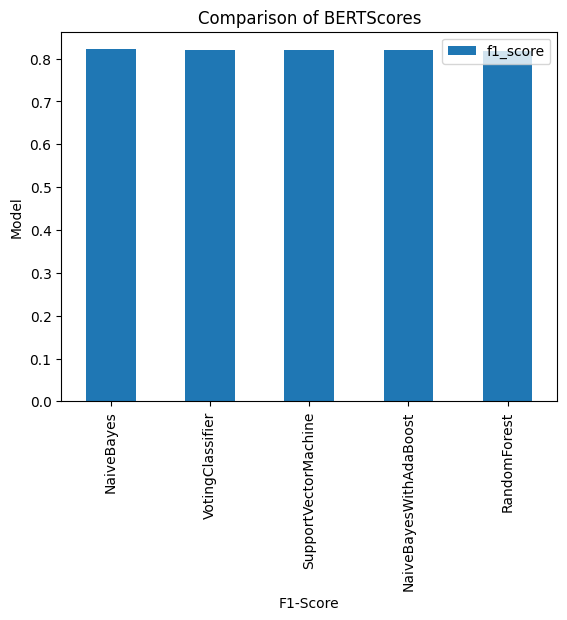

In [270]:
plt.figure(figsize=(7,5))
bert_score_df.sort_values(by="f1_score", ascending=False).plot(kind="bar")
plt.title("Comparison of BERTScores")
plt.xlabel("F1-Score")
plt.ylabel("Model")
plt.show()

INFERENCE: The results suggest that Naive Bayes, VotingClassifier (ensemble), and Support Vector Machine are well-suited for the summarization task, as they achieved high F1 scores. RandomForest, being a powerful ensemble method, performed slightly lower in this specific context.

In [15]:
# Load the BART model and tokenizer
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

def summarize(text, maxSummarylength=500):
    # Encode the text and summarize
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=maxSummarylength, min_length=int(maxSummarylength/5), length_penalty=10.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

def split_text_into_pieces(text, max_tokens=600, overlapPercent=10):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)

    # Calculate the overlap in tokens
    overlap_tokens = int(max_tokens * overlapPercent / 100)

    # Split the tokens into chunks of size max_tokens with overlap
    pieces = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens - overlap_tokens)]

    # Convert the token pieces back into text
    text_pieces = [tokenizer.decode(tokenizer.convert_tokens_to_ids(piece), skip_special_tokens=True) for piece in pieces]

    return text_pieces

def summarize_chunks(text, max_length=500):
    tokens = tokenizer.tokenize(text)
    expectedCountOfChunks = len(tokens) / max_length
    max_length = int(len(tokens) / expectedCountOfChunks) + 2

    # Break the text into pieces of max_length
    pieces = split_text_into_pieces(text, max_tokens=max_length)

    print("Number of pieces:", len(pieces))
    # Summarize each piece
    summaries = []
    k = 0
    for k in range(0, len(pieces)):
        piece = pieces[k]
        #print("****************************************************")
        #print("Piece:", (k+1), "out of", len(pieces), "pieces")
        #print(piece, "\n")
        summary = summarize(piece, maxSummarylength=150)
        #print("SUMMARY:", summary)
        summaries.append(summary)
        #print("****************************************************")

    concatenated_summary = ' '.join(summaries)
    print(concatenated_summary)
    return concatenated_summary

# Call the summarize_chunks function
#summary = summarize_chunks(X_train[0])
#print("Summary:")
#print(summary)

In [16]:
def rouge_scores(actual_summary, predicted_summary):
    rouge = Rouge()
    scores = rouge.get_scores(predicted_summary, actual_summary)
    return scores[0]['rouge-1']['f'], scores[0]['rouge-2']['f'], scores[0]['rouge-l']['f']

In [305]:
csv_file = "train_evaluation.csv"
with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["document", "actual_summary", "predicted_summary", "cosine_similarity", "rouge_1", "rouge_2", "rouge_L"]) # Add headers
    for i in range(100):
        print(f"\n###Document: {i+1}###\n")
        summary = summarize_chunks(X_train[i])
        cosine_sim = cosine_similarity(tfidf.transform([y_train[i]]), tfidf.transform([summary]))
        rouge_1, rouge_2, rouge_L = rouge_scores(y_train[i], summary)
        print(f"\ncosine similarity: {cosine_sim}")
        print(f"rouge_1: {rouge_1}")
        print(f"rouge_2: {rouge_2}")
        print(f"rouge_L: {rouge_L}\n")
        writer.writerow([X_train[i], y_train[i], summary, cosine_sim, rouge_1, rouge_2, rouge_L])


###Document: 1###

Number of pieces: 3
l appeal no one hundred and fifty - fifty - three one thousand, nine hundred and 50 - four one thousand,. 9 hundred and sixty appeal special leave award dated february fifty - one thousand. One thousand,Nine hundred and seventy surplus low paid workman entitled bonus therefore opinion though law rule company may permit appellant pay amount donation political fund proper expense deducted working available surplus light. appellant relates deduction call extraneous income matter considered court tata oil mill co ltd v ite workman others one see whether accordance decision case. claim deducting certain amount extraneous Income correct learned counsel. first item relates sum r three hundred and forty - seven lac said income year therefore taken account arriving gross profit. second item sum r one hundred and seventy - six lac respect rebate earned insurance. disagree next urged tribunal allowed sum r four hundred and seventy - six lac making provision

In [17]:
csv_file = "val_evaluation.csv"
with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["document", "actual_summary", "predicted_summary", "cosine_similarity", "rouge_1", "rouge_2", "rouge_L"]) # Add headers
    for i in range(20):
        print(f"\n###Document: {i+1}###\n")
        summary = summarize_chunks(X_val[i])
        cosine_sim = cosine_similarity(tfidf.transform([y_val[i]]), tfidf.transform([summary]))
        rouge_1, rouge_2, rouge_L = rouge_scores(y_val[i], summary)
        print(f"\ncosine similarity: {cosine_sim}")
        print(f"rouge_1: {rouge_1}")
        print(f"rouge_2: {rouge_2}")
        print(f"rouge_L: {rouge_L}\n")
        writer.writerow([X_val[i], y_val[i], summary, cosine_sim, rouge_1, rouge_2, rouge_L])


###Document: 1###

Number of pieces: 4
appeal fifty-two thousand, six hundred and fifty-nine appeal special leave judgement order dated march 3. patna high court misc case nine hundred and forty one thousand,Nine hundred and Fifty-six b k khanna p menon appellant p k chatterjee respondent april twenty-six judgment court delivered wanchoo j. Three contention accepted high court allowed writ petition adding interfering order relating expense made mr justice jamuar report september twenty-six one thousand, nine hundred and fifty-five order high court challenged u main contention behalf respondent court inquiry. Head must fail turning contention namely order september seven one thousand, nine hundred and fifty-six bad two assessor associated mr justice jamuar order passed enough say section twenty-24 one inquiry held competent. Head also must therefore fail bringing u main contention raised behalf respondent namely court inquiry became functus officio report made. Court inquiry decided se

In [35]:
# BART performance on Training data
train_bart = pd.read_csv("train_evaluation.csv")
train_bart

,document,actual_summary,predicted_summary,cosine_similarity,rouge_1,rouge_2,rouge_L
0,l appeal no one hundred and fifty-three one hu...,question appeal whether tribunal wrong allowin...,l appeal no one hundred and fifty - fifty - th...,[[0.52094881]],0.430493,0.197279,0.385650
1,minal appeal one hundred and ninety one thousa...,appellant resident palwal gurgaon district com...,minal appeal one hundred and ninety one thousa...,[[0.67296115]],0.481928,0.263220,0.369478
2,appeal one hundred and seventy-seven one thous...,government issued notification december three ...,appeal one hundred and seventy - seven one tho...,[[0.73027975]],0.519685,0.293963,0.417323
3,appeal two hundred and ninety-eight one thousa...,respondent challenged appellant election tribu...,appeal two hundred and ninety - eight one thou...,[[0.66698912]],0.400000,0.190476,0.362353
4,"appeal twelve one thousand, nine hundred and f...",though isolated transaction purchase raw mate ...,"appeal twelve one thousand, nine hundred and f...",[[0.44667697]],0.324675,0.148492,0.285714
...,...,...,...,...,...,...,...
95,civil appeal three hundred fifty-eight n sinha...,application article two hundred and twenty-six...,Civil appeal three hundred fifty - eight n sin...,[[0.5879528]],0.303797,0.091106,0.221519
96,"fifty-four one thousand, nine hundred and fift...",habeas corpus proceeding court regard legality...,"fifty - four one thousand, nine hundred and fi...",[[0.20490829]],0.201342,0.033708,0.134228
97,appeal three hundred and ninety-eight one thou...,respondent executed agreement sell house order...,appeal three hundred and ninety - eight one th...,[[0.46702381]],0.411985,0.165375,0.374532
98,"one hundred and sixty one thousand, nine hundr...",section two supreme court advocate practice hi...,"one hundred and sixty one thousand, nine hundr...",[[0.82905037]],0.356436,0.108644,0.264026


In [36]:
train_bart["cosine_similarity_"] = train_bart["cosine_similarity"].astype(str)

# Define a lambda function to remove square brackets
remove_brackets = lambda x: x.replace("[", "").replace("]", "")

train_bart['cosine_similarity_'] = train_bart['cosine_similarity_'].apply(remove_brackets).astype("float64")
train_bart

,document,actual_summary,predicted_summary,cosine_similarity,rouge_1,rouge_2,rouge_L,cosine_similarity_
0,l appeal no one hundred and fifty-three one hu...,question appeal whether tribunal wrong allowin...,l appeal no one hundred and fifty - fifty - th...,[[0.52094881]],0.430493,0.197279,0.385650,0.520949
1,minal appeal one hundred and ninety one thousa...,appellant resident palwal gurgaon district com...,minal appeal one hundred and ninety one thousa...,[[0.67296115]],0.481928,0.263220,0.369478,0.672961
2,appeal one hundred and seventy-seven one thous...,government issued notification december three ...,appeal one hundred and seventy - seven one tho...,[[0.73027975]],0.519685,0.293963,0.417323,0.730280
3,appeal two hundred and ninety-eight one thousa...,respondent challenged appellant election tribu...,appeal two hundred and ninety - eight one thou...,[[0.66698912]],0.400000,0.190476,0.362353,0.666989
4,"appeal twelve one thousand, nine hundred and f...",though isolated transaction purchase raw mate ...,"appeal twelve one thousand, nine hundred and f...",[[0.44667697]],0.324675,0.148492,0.285714,0.446677
...,...,...,...,...,...,...,...,...
95,civil appeal three hundred fifty-eight n sinha...,application article two hundred and twenty-six...,Civil appeal three hundred fifty - eight n sin...,[[0.5879528]],0.303797,0.091106,0.221519,0.587953
96,"fifty-four one thousand, nine hundred and fift...",habeas corpus proceeding court regard legality...,"fifty - four one thousand, nine hundred and fi...",[[0.20490829]],0.201342,0.033708,0.134228,0.204908
97,appeal three hundred and ninety-eight one thou...,respondent executed agreement sell house order...,appeal three hundred and ninety - eight one th...,[[0.46702381]],0.411985,0.165375,0.374532,0.467024
98,"one hundred and sixty one thousand, nine hundr...",section two supreme court advocate practice hi...,"one hundred and sixty one thousand, nine hundr...",[[0.82905037]],0.356436,0.108644,0.264026,0.829050


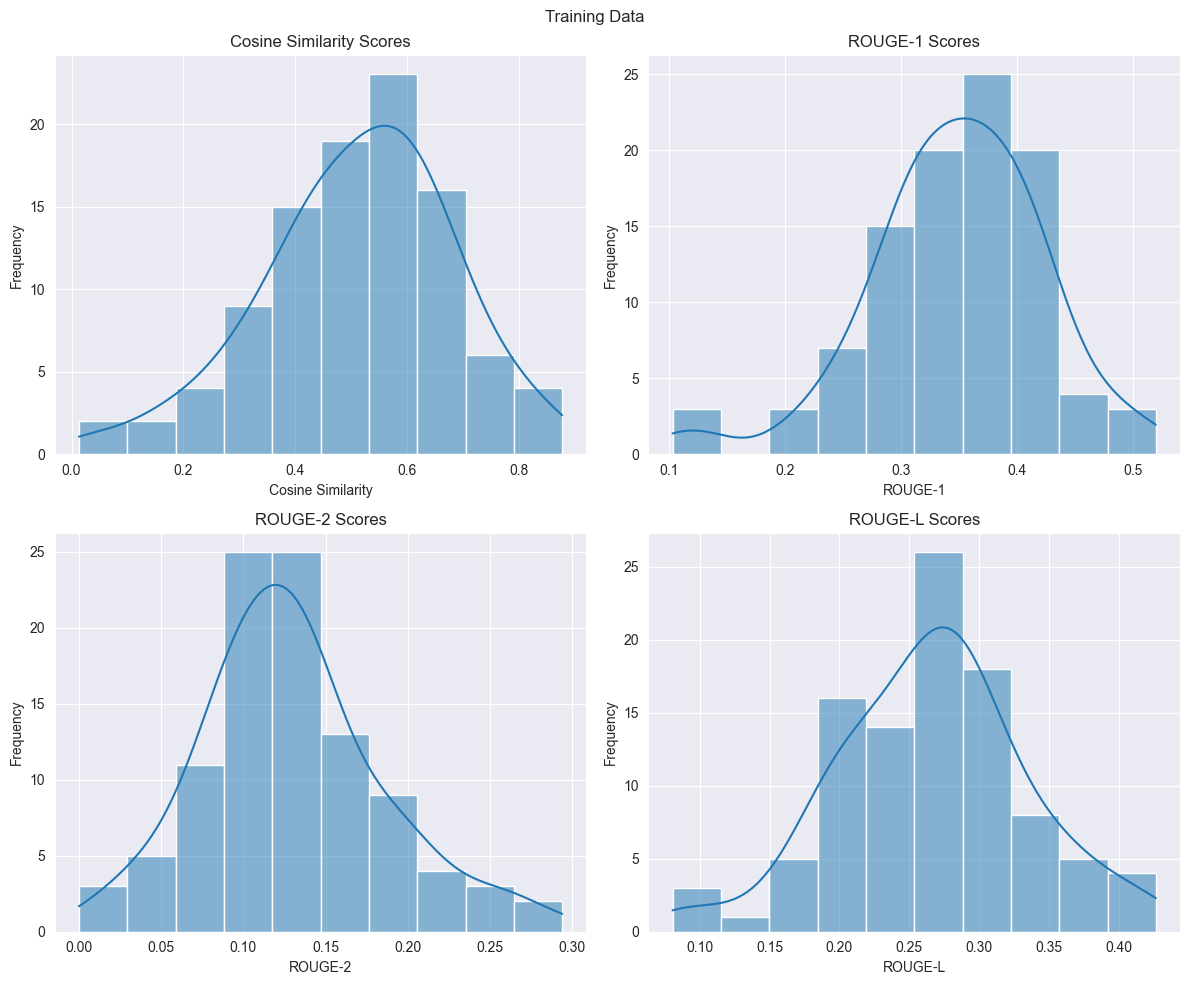

In [37]:
# Create subplots for histograms with KDE for Cosine Similarities and ROUGE Scores
cosine_similarity_scores = train_bart["cosine_similarity_"]
rouge_1_scores = train_bart["rouge_1"]
rouge_2_scores = train_bart["rouge_2"]
rouge_L_scores = train_bart["rouge_L"]


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Cosine Similarity subplot
sns.histplot(cosine_similarity_scores, kde=True, bins=10, ax=axes[0, 0])
axes[0, 0].set_title('Cosine Similarity Scores')
axes[0, 0].set_xlabel('Cosine Similarity')
axes[0, 0].set_ylabel('Frequency')

# ROUGE-1 subplot
sns.histplot(rouge_1_scores, kde=True, bins=10, ax=axes[0, 1])
axes[0, 1].set_title('ROUGE-1 Scores')
axes[0, 1].set_xlabel('ROUGE-1')
axes[0, 1].set_ylabel('Frequency')

# ROUGE-2 subplot
sns.histplot(rouge_2_scores, kde=True, bins=10, ax=axes[1, 0])
axes[1, 0].set_title('ROUGE-2 Scores')
axes[1, 0].set_xlabel('ROUGE-2')
axes[1, 0].set_ylabel('Frequency')

# ROUGE-L subplot
sns.histplot(rouge_L_scores, kde=True, bins=10, ax=axes[1, 1])
axes[1, 1].set_title('ROUGE-L Scores')
axes[1, 1].set_xlabel('ROUGE-L')
axes[1, 1].set_ylabel('Frequency')

plt.suptitle('Training Data')
plt.tight_layout()
plt.show()

INFERENCE: For training data, most of the documents have a cosine similarity around 0.6

INFERENCE: Most of the documents have ROUGE-1 of approximately 0.38, which suggests that most documents have a moderate level of overlap between the predicted summary and the reference summary in terms of unigrams.

INFERENCE: Most of the documents have ROUGE-2 of approximately 0.28 suggests a moderate level of overlap between the predicted summary and the reference summary in terms of bigrams.

INFERENCE: Most of the documents have ROUGE-L of approximately 0.28 suggests a moderate level of overlap between the predicted summary and the reference summary in terms of longest common subsequence(LCS).

In [40]:
avg_rouge_1 = train_bart["rouge_1"].mean()
avg_rouge_2 = train_bart["rouge_2"].mean()
avg_rouge_L = train_bart["rouge_L"].mean()

rouge_df = pd.DataFrame([[avg_rouge_1, avg_rouge_2, avg_rouge_L]], columns=["ROUGE-1", "ROUGE-2", "ROUGE-L"], index=["BART"])
rouge_df

,ROUGE-1,ROUGE-2,ROUGE-L
BART,0.347682,0.129249,0.265748


In [39]:
avg_rouge_1

0.3476818029438572

In [25]:
# BART performance on Validation data
val_bart = pd.read_csv("val_evaluation.csv")
val_bart

,document,actual_summary,predicted_summary,cosine_similarity,rouge_1,rouge_2,rouge_L
0,"appeal fifty-two thousand, six hundred and fif...",government india section twenty-four ordered e...,"appeal fifty-two thousand, six hundred and fif...",[[0.5986362]],0.412698,0.199005,0.380952
1,"appeal ninety-six one thousand, nine hundred a...",eldee one branch respondent advanced loan anot...,"appeal ninety-six one thousand, nine hundred a...",[[0.41946739]],0.227723,0.113333,0.188119
2,appeal no two hundred and seventy-two two hund...,dispute appellant company workman referred ind...,appeal no two hundred and seventy-two. appeal ...,[[0.76902401]],0.408163,0.212914,0.352041
3,"appeal fifty-nine one thousand, nine hundred a...",jurisdiction high court matter mooroetax refer...,"appeal fifty-nine one thousand, nine hundred a...",[[0.38716048]],0.308123,0.051282,0.240896
4,"civil appeal thirty-two thousand, five hundred...",appellant whose permit plying stage carriage s...,"Civil appeal thirty-two thousand, five hundred...",[[0.67207918]],0.363636,0.138940,0.267045
5,"appeal seven hundred and seven one thousand, n...",appellant appointed clerk state bank india dec...,"appeal seven hundred and seven one thousand, n...",[[0.61300736]],0.433180,0.234177,0.368664
6,"appeal four hundred and fourteen one thousand,...",scotish masonic institution known grand lodge ...,"appeal four hundred and fourteen one thousand,...",[[0.51189016]],0.463303,0.249292,0.385321
7,appeal no five hundred and fifty-five five hun...,dispute appellant cooperative bank taken loan ...,appeal no five hundred and fifty-five five hun...,[[0.27740448]],0.264840,0.082019,0.200913
8,appeal no four hundred and twenty-nine four hu...,electricity supplied appellant respon dent sta...,appeal no four hundred and twenty-nine. Four h...,[[0.63516816]],0.470588,0.243309,0.382353
9,"eighty-seven one thousand, nine hundred and fi...",petitioner challenged constitutional validity ...,Petitioner v viswanatha sastri r ganapathy iye...,[[0.6900853]],0.441324,0.155446,0.347041


In [29]:
val_bart["cosine_similarity_"] = val_bart["cosine_similarity"].astype(str)

# Define a lambda function to remove square brackets
remove_brackets = lambda x: x.replace("[", "").replace("]", "")

val_bart['cosine_similarity_'] = val_bart['cosine_similarity_'].apply(remove_brackets).astype("float64")
val_bart

,document,actual_summary,predicted_summary,cosine_similarity,rouge_1,rouge_2,rouge_L,cosine_similarity_
0,"appeal fifty-two thousand, six hundred and fif...",government india section twenty-four ordered e...,"appeal fifty-two thousand, six hundred and fif...",[[0.5986362]],0.412698,0.199005,0.380952,0.598636
1,"appeal ninety-six one thousand, nine hundred a...",eldee one branch respondent advanced loan anot...,"appeal ninety-six one thousand, nine hundred a...",[[0.41946739]],0.227723,0.113333,0.188119,0.419467
2,appeal no two hundred and seventy-two two hund...,dispute appellant company workman referred ind...,appeal no two hundred and seventy-two. appeal ...,[[0.76902401]],0.408163,0.212914,0.352041,0.769024
3,"appeal fifty-nine one thousand, nine hundred a...",jurisdiction high court matter mooroetax refer...,"appeal fifty-nine one thousand, nine hundred a...",[[0.38716048]],0.308123,0.051282,0.240896,0.387160
4,"civil appeal thirty-two thousand, five hundred...",appellant whose permit plying stage carriage s...,"Civil appeal thirty-two thousand, five hundred...",[[0.67207918]],0.363636,0.138940,0.267045,0.672079
5,"appeal seven hundred and seven one thousand, n...",appellant appointed clerk state bank india dec...,"appeal seven hundred and seven one thousand, n...",[[0.61300736]],0.433180,0.234177,0.368664,0.613007
6,"appeal four hundred and fourteen one thousand,...",scotish masonic institution known grand lodge ...,"appeal four hundred and fourteen one thousand,...",[[0.51189016]],0.463303,0.249292,0.385321,0.511890
7,appeal no five hundred and fifty-five five hun...,dispute appellant cooperative bank taken loan ...,appeal no five hundred and fifty-five five hun...,[[0.27740448]],0.264840,0.082019,0.200913,0.277404
8,appeal no four hundred and twenty-nine four hu...,electricity supplied appellant respon dent sta...,appeal no four hundred and twenty-nine. Four h...,[[0.63516816]],0.470588,0.243309,0.382353,0.635168
9,"eighty-seven one thousand, nine hundred and fi...",petitioner challenged constitutional validity ...,Petitioner v viswanatha sastri r ganapathy iye...,[[0.6900853]],0.441324,0.155446,0.347041,0.690085


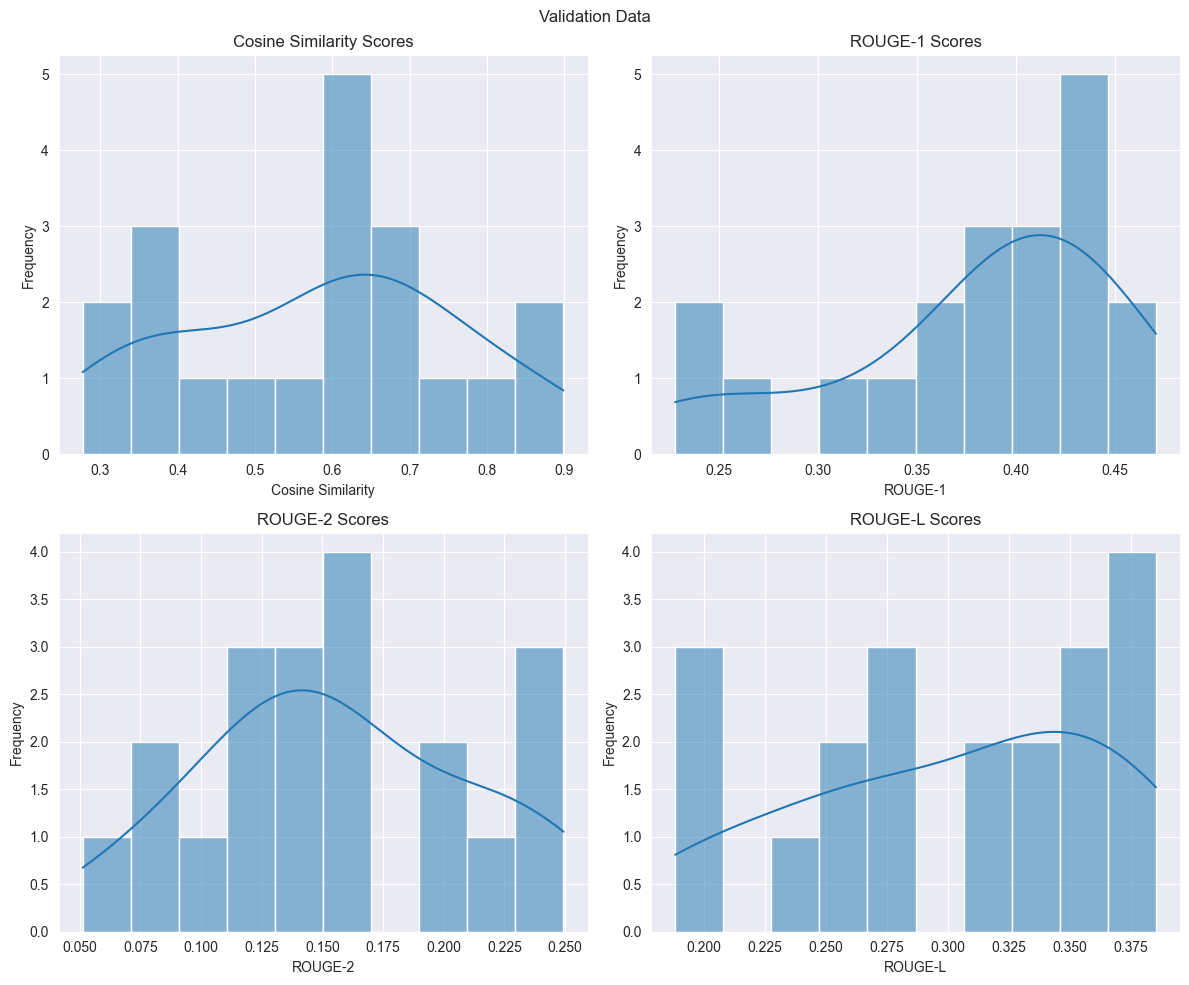

In [27]:
# Create subplots for histograms with KDE for Cosine Similarities and ROUGE Scores
cosine_similarity_scores_val = val_bart["cosine_similarity_"]
rouge_1_scores_val = val_bart["rouge_1"]
rouge_2_scores_val = val_bart["rouge_2"]
rouge_L_scores_val = val_bart["rouge_L"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Cosine Similarity subplot
sns.histplot(cosine_similarity_scores_val, kde=True, bins=10, ax=axes[0, 0])
axes[0, 0].set_title('Cosine Similarity Scores')
axes[0, 0].set_xlabel('Cosine Similarity')
axes[0, 0].set_ylabel('Frequency')

# ROUGE-1 subplot
sns.histplot(rouge_1_scores_val, kde=True, bins=10, ax=axes[0, 1])
axes[0, 1].set_title('ROUGE-1 Scores')
axes[0, 1].set_xlabel('ROUGE-1')
axes[0, 1].set_ylabel('Frequency')

# ROUGE-2 subplot
sns.histplot(rouge_2_scores_val, kde=True, bins=10, ax=axes[1, 0])
axes[1, 0].set_title('ROUGE-2 Scores')
axes[1, 0].set_xlabel('ROUGE-2')
axes[1, 0].set_ylabel('Frequency')

# ROUGE-L subplot
sns.histplot(rouge_L_scores_val, kde=True, bins=10, ax=axes[1, 1])
axes[1, 1].set_title('ROUGE-L Scores')
axes[1, 1].set_xlabel('ROUGE-L')
axes[1, 1].set_ylabel('Frequency')

plt.suptitle('Validation Data')
plt.tight_layout()
plt.show()

INFERENCE: For validation data, most of the documents have a cosine similarity around 0.6

INFERENCE: Most of the documents have ROUGE-1 of approximately 0.44, which suggests that most documents have a moderate level of overlap between the predicted summary and the reference summary in terms of unigrams.

INFERENCE: Most of the documents have ROUGE-2 of approximately 0.16 suggests a moderate level of overlap between the predicted summary and the reference summary in terms of bigrams.

INFERENCE: Most of the documents have ROUGE-L of approximately 0.375 suggests a moderate level of overlap between the predicted summary and the reference summary in terms of longest common subsequence(LCS).

In [31]:
print("### TRAINING DATA ###")
print(f"Average Cosine Similarity: {train_bart['cosine_similarity_'].mean()}")
print(f"Average ROUGE-1 Score: {train_bart['rouge_1'].mean()}")
print(f"Average ROUGE-2 Score: {train_bart['rouge_2'].mean()}")
print(f"Average ROUGE-L Score: {train_bart['rouge_L'].mean()}")

### TRAINING DATA ###
Average Cosine Similarity: 0.5127791113
Average ROUGE-1 Score: 0.3476818029438572
Average ROUGE-2 Score: 0.12924941499345619
Average ROUGE-L Score: 0.26574780874428366


In [28]:
print("### VALIDATION DATA ###")
print(f"Average Cosine Similarity: {val_bart['cosine_similarity_'].mean()}")
print(f"Average ROUGE-1 Score: {val_bart['rouge_1'].mean()}")
print(f"Average ROUGE-2 Score: {val_bart['rouge_2'].mean()}")
print(f"Average ROUGE-L Score: {val_bart['rouge_L'].mean()}")

### VALIDATION DATA ###
Average Cosine Similarity: 0.582858267
Average ROUGE-1 Score: 0.37957394080516066
Average ROUGE-2 Score: 0.15535966626891368
Average ROUGE-L Score: 0.30273883119394307


In [33]:
csv_file = "train_summaries.csv"
with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["document", "actual_summary", "predicted_summary", "cosine_similarity"]) # Add headers
    for i in range(25):
        print(f"\n###Document: {i+1}###\n")
        summary = summarize_chunks(X_train[i])
        cosine_sim = cosine_similarity(tfidf.transform([y_train[i]]), tfidf.transform([summary]))
        print(f"\ncosine similarity: {cosine_sim}")
        writer.writerow([X_train[i], y_train[i], summary, cosine_sim])


###Document: 1###

Number of pieces: 3
l appeal no one hundred and fifty-three one hundred, fifty-one thousand, nine hundred and sixty appeal special leave award dated february. industrial tribunal bombay reference two hundred and twelve. n andley j b dadachanji appellant appears already paid four twelve month basic wage bonus relevant year respondent claimed rate six months basic wage subject minimum r two hundred per employee. r two Hundred and fifty per employee per employee one 100 and sixty-nine. Tribunal conceded amount could deducted profit view concession prepared allow deduction amount extraneous income second item sum r one hundred and seventy-six lac respect rebate earned insurance appellant company virtue holding principal agency obviously part insurance business. Third item sum sum r three thirty-three lac gain foreign exchange transaction transaction carried normal course business. Tribunal allowed five month basic wage bonus respondent work r one thousand, six hundred a

In [34]:
csv_file = "train_summaries[1].csv"
with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["document", "actual_summary", "predicted_summary", "cosine_similarity"]) # Add headers
    for i in range(25, 100, 1):
        print(f"\n###Document: {i+1}###\n")
        summary = summarize_chunks(X_train[i])
        cosine_sim = cosine_similarity(tfidf.transform([y_train[i]]), tfidf.transform([summary]))
        print(f"\ncosine similarity: {cosine_sim}")
        writer.writerow([X_train[i], y_train[i], summary, cosine_sim])


###Document: 26###

Number of pieces: 7
appeal two hundred and eighty-five one thousand, nine hundred and fifty-nine appeal special leave judgment decree dated 13th july. Patna high court j c four hundred and four 1 thousand, 9 hundred and 50-four c setalvad attorney general india section p varma appellant v viswanatha sastri suresh aggarwala p singh respondent. judgment court delivered five hundred and twenty-four sinha cj. High court ramaswami c j raj kishore prasad j heard reference come conclusion judgment dated july 13 one thousand, nine hundred and fifty-six reference answered affirmative. High court prayed high court pleased grant leave appeal supreme court india grant necessary certificate. High court case involved case unable accept argument correct possible u hold substantial question law interpretation constitution involved case question issue purely matter construction section 2g bihar sale tax act question decided court favour state bihar petitioner argued behalf petition

In [35]:
df = pd.read_csv("train_summaries.csv")
for i in range(len(df)):
    df.predicted_summary[i] = df.predicted_summary[i].replace("\xa0", " ")

In [36]:
df1 = pd.read_csv("train_summaries[1].csv")
for i in range(len(df1)):
    df1.predicted_summary[i] = df1.predicted_summary[i].replace("\xa0", " ")

In [37]:
df

,document,actual_summary,predicted_summary,cosine_similarity
0,l appeal no one hundred and fifty-three one hu...,question appeal whether tribunal wrong allowin...,l appeal no one hundred and fifty-three one hu...,[[0.25556978]]
1,minal appeal one hundred and ninety one thousa...,appellant resident palwal gurgaon district com...,minal appeal one hundred and ninety one thousa...,[[0.60946341]]
2,appeal one hundred and seventy-seven one thous...,government issued notification december three ...,appeal one hundred and seventy-seven one thous...,[[0.48934325]]
3,appeal two hundred and ninety-eight one thousa...,respondent challenged appellant election tribu...,appeal two hundred and ninety-eight one thousa...,[[0.72655359]]
4,"appeal twelve one thousand, nine hundred and f...",though isolated transaction purchase raw mate ...,"appeal twelve one thousand, nine hundred and f...",[[0.39996483]]
5,"appeal forty-five thousand, seven hundred and ...",respondent no four nine displaced person pakis...,"appeal forty-five thousand, seven hundred and ...",[[0.64173169]]
6,iminal appeal no one hundred and seventy-six o...,section one hundred and sixty-two code crimina...,iminal appeal no one hundred and seventy-seven...,[[0.05135214]]
7,minal appeal no thirty-nine forty-nine one tho...,respondent appeal convicted magistrate offence...,minal appeal no thirty-nine forty-nine one tho...,[[0.74843227]]
8,appeal five hundred and ninety-six one thousan...,free press company private limited company car...,appeal five hundred and ninety-six one thousan...,[[0.64906945]]
9,appeal no one hundred and fifty-five one hundr...,appellant held personal inams governed bombay ...,appeal no one hundred and fifty-five one hundr...,[[0.43349102]]


In [38]:
df1

,document,actual_summary,predicted_summary,cosine_similarity
0,appeal two hundred and eighty-five one thousan...,appellant corporation assessed sale tax sectio...,appeal two hundred and eighty-five one thousan...,[[0.41620312]]
1,appeal seven hundred and fifty-four one thousa...,appellant respondent displaced person west pak...,appeal seven hundred and fifty-four one thousa...,[[0.72435253]]
2,appeal three hundred and thirty-two one thousa...,municipal board pushkar passed resolution may ...,appeal three hundred and thirty-two one thousa...,[[0.79526858]]
3,appeal three hundred and sixty-six one thousan...,appellant registered holder five hundred share...,appeal three hundred and sixty-six one thousan...,[[0.36084375]]
4,appeal six hundred and eighty-eight one thousa...,appellant issued notice respondent section thr...,appeal six hundred and eighty-eight one thousa...,[[0.5678969]]
...,...,...,...,...
70,civil appeal three hundred fifty-eight n sinha...,application article two hundred and twenty-six...,Civil appeal three hundred fifty-eight n sinha...,[[0.57615887]]
71,"fifty-four one thousand, nine hundred and fift...",habeas corpus proceeding court regard legality...,"Fifty-four one thousand, nine hundred and fift...",[[0.26184008]]
72,appeal three hundred and ninety-eight one thou...,respondent executed agreement sell house order...,appeal three hundred and ninety-eight one thou...,[[0.39913273]]
73,"one hundred and sixty one thousand, nine hundr...",section two supreme court advocate practice hi...,"one hundred and sixty one thousand, nine hundr...",[[0.81846732]]


In [39]:
merged_df = pd.concat([df, df1], ignore_index=True)

merged_df

,document,actual_summary,predicted_summary,cosine_similarity
0,l appeal no one hundred and fifty-three one hu...,question appeal whether tribunal wrong allowin...,l appeal no one hundred and fifty-three one hu...,[[0.25556978]]
1,minal appeal one hundred and ninety one thousa...,appellant resident palwal gurgaon district com...,minal appeal one hundred and ninety one thousa...,[[0.60946341]]
2,appeal one hundred and seventy-seven one thous...,government issued notification december three ...,appeal one hundred and seventy-seven one thous...,[[0.48934325]]
3,appeal two hundred and ninety-eight one thousa...,respondent challenged appellant election tribu...,appeal two hundred and ninety-eight one thousa...,[[0.72655359]]
4,"appeal twelve one thousand, nine hundred and f...",though isolated transaction purchase raw mate ...,"appeal twelve one thousand, nine hundred and f...",[[0.39996483]]
...,...,...,...,...
95,civil appeal three hundred fifty-eight n sinha...,application article two hundred and twenty-six...,Civil appeal three hundred fifty-eight n sinha...,[[0.57615887]]
96,"fifty-four one thousand, nine hundred and fift...",habeas corpus proceeding court regard legality...,"Fifty-four one thousand, nine hundred and fift...",[[0.26184008]]
97,appeal three hundred and ninety-eight one thou...,respondent executed agreement sell house order...,appeal three hundred and ninety-eight one thou...,[[0.39913273]]
98,"one hundred and sixty one thousand, nine hundr...",section two supreme court advocate practice hi...,"one hundred and sixty one thousand, nine hundr...",[[0.81846732]]


In [40]:
merged_df.actual_summary[39]

'appellant descendant former ruling chief lost exemption land revenue result operation section three cp berar revocation land revenue exemption act one thousand, nine hundred and forty-eight applied pension money grant provision section five act petition rejected state government without reason recorded filed writ petition article two hundred and twenty-six high court held granting pension completely within discretion government petition therefore incompetent appeal supreme court appellant contended rejection petition without reason given amounted decision condition grant pension satisfied obligatory state government make grant money pension behalf state government reliance placed word section fifty-two enquiry respect application government may pas order deems fit directory word may used section fifty-three held sub section two three section five must considered separately sub section two application grant money pensionhad considered government could deal several way notwithstanding a

In [41]:
case_types = ["Industrial", "Criminal", "Property", "Administrative", "Industrial", "Property", "Criminal", "Environment", "Tax", "Property", "Property",
              "Industrial", "Tax", "Property", "Environment", "Criminal", "Tax", "Tax", "Industrial", "Tax", "Property", "Tax", "Tax", "Civil",
              "Civil", "Tax", "Administrative", "Administrative", "Tax", "Tax", "Tax", "Tax", "Civil", "Tax", "Administrative", "Criminal", "Property",
              "Civil", "Tax", "Administrative"]

# Labelled data
df2 = merged_df[:40]
df2["case_type"] = case_types

# Unlabelled data
df3 = merged_df[40:]

In [42]:
df2

,document,actual_summary,predicted_summary,cosine_similarity,case_type
0,l appeal no one hundred and fifty-three one hu...,question appeal whether tribunal wrong allowin...,l appeal no one hundred and fifty-three one hu...,[[0.25556978]],Industrial
1,minal appeal one hundred and ninety one thousa...,appellant resident palwal gurgaon district com...,minal appeal one hundred and ninety one thousa...,[[0.60946341]],Criminal
2,appeal one hundred and seventy-seven one thous...,government issued notification december three ...,appeal one hundred and seventy-seven one thous...,[[0.48934325]],Property
3,appeal two hundred and ninety-eight one thousa...,respondent challenged appellant election tribu...,appeal two hundred and ninety-eight one thousa...,[[0.72655359]],Administrative
4,"appeal twelve one thousand, nine hundred and f...",though isolated transaction purchase raw mate ...,"appeal twelve one thousand, nine hundred and f...",[[0.39996483]],Industrial
5,"appeal forty-five thousand, seven hundred and ...",respondent no four nine displaced person pakis...,"appeal forty-five thousand, seven hundred and ...",[[0.64173169]],Property
6,iminal appeal no one hundred and seventy-six o...,section one hundred and sixty-two code crimina...,iminal appeal no one hundred and seventy-seven...,[[0.05135214]],Criminal
7,minal appeal no thirty-nine forty-nine one tho...,respondent appeal convicted magistrate offence...,minal appeal no thirty-nine forty-nine one tho...,[[0.74843227]],Environment
8,appeal five hundred and ninety-six one thousan...,free press company private limited company car...,appeal five hundred and ninety-six one thousan...,[[0.64906945]],Tax
9,appeal no one hundred and fifty-five one hundr...,appellant held personal inams governed bombay ...,appeal no one hundred and fifty-five one hundr...,[[0.43349102]],Property


In [43]:
df3

,document,actual_summary,predicted_summary,cosine_similarity
40,appeal no four hundred and fifteen four hundre...,quilon municipality levied pre constitution pe...,appeal no four hundred and fifteen four hundre...,[[0.62450728]]
41,"appeal nine one thousand, nine hundred and six...",appellant respondent rival candidate election ...,"appeal nine one thousand, nine hundred and six...",[[0.49474771]]
42,appeal fifty-two sixty appeal judgment decree ...,"january one thousand, nine hundred and thirty-...",appeal fifty-two sixty appeal judgment decree ...,[[0.48155781]]
43,appeal three hundred and fifty-six fifty-eight...,owner certain plot land granted perpetual leas...,appeal three hundred and fifty-six fifty-eight...,[[0.20082916]]
44,l appeal one hundred and thirty-five one thous...,appellant firm carried business forest lessee ...,l appeal one hundred and thirty-five one thous...,[[0.62893593]]
45,"iminal appeal fifty-eight one thousand, nine h...",respondent arrested police constable ground sm...,"iminal appeal fifty-eight one thousand, nine h...",[[0.24886423]]
46,ivil appeal two hundred and sixty-nine one tho...,notice served appellant state inviting attenti...,ivil appeal two hundred and sixty-nine one tho...,[[0.25693568]]
47,"n one hundred and twenty-eight one thousand, n...",section three bombay prevention excommunicatio...,"n one hundred and twenty-eight one thousand, n...",[[0.78177598]]
48,minal appeal one hundred and twenty-four one t...,search premise appellant one complete working ...,minal appeal one hundred and twenty-24 one tho...,[[0.37636618]]
49,minal appeal one hundred and fifty-four one th...,question arising determination whether chairma...,minal appeal one hundred and fifty-four one th...,[[0.49378301]]


In [44]:
df2.case_type.value_counts()

case_type
Tax               14
Property           7
Administrative     5
Industrial         4
Criminal           4
Civil              4
Environment        2
Name: count, dtype: int64

In [45]:
actual_summary_tfidf = tfidf.transform(df2["actual_summary"])
nb_model.fit(actual_summary_tfidf, case_types)

MultinomialNB(alpha=0.7, fit_prior=False)

In [46]:
unlabelled_summary_tfidf = tfidf.transform(df3["actual_summary"])

In [47]:
pseudo_pred = nb_model.predict(unlabelled_summary_tfidf)

In [48]:
len(pseudo_pred)

60

In [49]:
X_combined = pd.concat([df2["actual_summary"], df3["actual_summary"]])
y_combined = pd.concat([df2["case_type"], pd.Series(pseudo_pred)], ignore_index=True)

In [50]:
nb_model.fit(tfidf.transform(X_combined), y_combined)

MultinomialNB(alpha=0.7, fit_prior=False)

In [51]:
y_combined

0         Industrial
1           Criminal
2           Property
3     Administrative
4         Industrial
           ...      
95               Tax
96          Criminal
97               Tax
98               Tax
99          Criminal
Length: 100, dtype: object

In [52]:
labels_100 = pd.concat([X_combined, y_combined], axis=1)
labels_100.columns = ["actual_summary", "case_type"]
labels_100

,actual_summary,case_type
0,question appeal whether tribunal wrong allowin...,Industrial
1,appellant resident palwal gurgaon district com...,Criminal
2,government issued notification december three ...,Property
3,respondent challenged appellant election tribu...,Administrative
4,though isolated transaction purchase raw mate ...,Industrial
...,...,...
95,application article two hundred and twenty-six...,Tax
96,habeas corpus proceeding court regard legality...,Criminal
97,respondent executed agreement sell house order...,Tax
98,section two supreme court advocate practice hi...,Tax


In [53]:
merged_df["case_type"] = labels_100["case_type"]
merged_df

,document,actual_summary,predicted_summary,cosine_similarity,case_type
0,l appeal no one hundred and fifty-three one hu...,question appeal whether tribunal wrong allowin...,l appeal no one hundred and fifty-three one hu...,[[0.25556978]],Industrial
1,minal appeal one hundred and ninety one thousa...,appellant resident palwal gurgaon district com...,minal appeal one hundred and ninety one thousa...,[[0.60946341]],Criminal
2,appeal one hundred and seventy-seven one thous...,government issued notification december three ...,appeal one hundred and seventy-seven one thous...,[[0.48934325]],Property
3,appeal two hundred and ninety-eight one thousa...,respondent challenged appellant election tribu...,appeal two hundred and ninety-eight one thousa...,[[0.72655359]],Administrative
4,"appeal twelve one thousand, nine hundred and f...",though isolated transaction purchase raw mate ...,"appeal twelve one thousand, nine hundred and f...",[[0.39996483]],Industrial
...,...,...,...,...,...
95,civil appeal three hundred fifty-eight n sinha...,application article two hundred and twenty-six...,Civil appeal three hundred fifty-eight n sinha...,[[0.57615887]],Tax
96,"fifty-four one thousand, nine hundred and fift...",habeas corpus proceeding court regard legality...,"Fifty-four one thousand, nine hundred and fift...",[[0.26184008]],Criminal
97,appeal three hundred and ninety-eight one thou...,respondent executed agreement sell house order...,appeal three hundred and ninety-eight one thou...,[[0.39913273]],Tax
98,"one hundred and sixty one thousand, nine hundr...",section two supreme court advocate practice hi...,"one hundred and sixty one thousand, nine hundr...",[[0.81846732]],Tax


In [54]:
merged_df["case_type"].replace("Business", "Industrial", inplace=True)

In [55]:
merged_df.case_type.value_counts()

case_type
Tax               49
Criminal          16
Property          15
Industrial         8
Administrative     6
Civil              4
Environment        2
Name: count, dtype: int64

In [69]:
csv_file = "val_summaries.csv"
with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["document", "actual_summary", "predicted_summary", "cosine_similarity"]) # Add headers
    for i in range(20):
        print(f"\n###Document: {i+1}###\n")
        summary = summarize_chunks(X_val[i])
        cosine_sim = cosine_similarity(tfidf.transform([y_val[i]]), tfidf.transform([summary]))
        print(f"\ncosine similarity: {cosine_sim}")
        writer.writerow([X_val[i], y_val[i], summary, cosine_sim])


###Document: 1###

Number of pieces: 4
appeal fifty-two thousand, six hundred and fifty-nine appeal special leave judgement order dated march 3. patna high court misc case nine hundred and forty one thousand,Nine hundred and Fifty-six b k khanna p menon appellant p k chatterjee respondent april twenty-six judgment court delivered wanchoo j. Three contention accepted high court allowed writ petition adding interfering order relating expense made mr justice jamuar report september twenty-six one thousand, nine hundred and fifty-five order high court challenged u main contention behalf respondent court inquiry. Head must fail turning contention namely order september seven one thousand, nine hundred and fifty-six bad two assessor associated mr justice jamuar order passed enough say section twenty-24 one inquiry held competent. Head also must therefore fail bringing u main contention raised behalf respondent namely court inquiry became functus officio report made. Court inquiry decided se

In [70]:
val_df = pd.read_csv("val_summaries.csv")
val_df

,document,actual_summary,predicted_summary,cosine_similarity
0,"appeal fifty-two thousand, six hundred and fif...",government india section twenty-four ordered e...,"appeal fifty-two thousand, six hundred and fif...",[[0.5986362]]
1,"appeal ninety-six one thousand, nine hundred a...",eldee one branch respondent advanced loan anot...,"appeal ninety-six one thousand, nine hundred a...",[[0.41946739]]
2,appeal no two hundred and seventy-two two hund...,dispute appellant company workman referred ind...,appeal no two hundred and seventy-two. appeal ...,[[0.76902401]]
3,"appeal fifty-nine one thousand, nine hundred a...",jurisdiction high court matter mooroetax refer...,"appeal fifty-nine one thousand, nine hundred a...",[[0.38716048]]
4,"civil appeal thirty-two thousand, five hundred...",appellant whose permit plying stage carriage s...,"Civil appeal thirty-two thousand, five hundred...",[[0.67207918]]
5,"appeal seven hundred and seven one thousand, n...",appellant appointed clerk state bank india dec...,"appeal seven hundred and seven one thousand, n...",[[0.61300736]]
6,"appeal four hundred and fourteen one thousand,...",scotish masonic institution known grand lodge ...,"appeal four hundred and fourteen one thousand,...",[[0.51189016]]
7,appeal no five hundred and fifty-five five hun...,dispute appellant cooperative bank taken loan ...,appeal no five hundred and fifty-five five hun...,[[0.27740448]]
8,appeal no four hundred and twenty-nine four hu...,electricity supplied appellant respon dent sta...,appeal no four hundred and twenty-nine. Four h...,[[0.63516816]]
9,"eighty-seven one thousand, nine hundred and fi...",petitioner challenged constitutional validity ...,Petitioner v viswanatha sastri r ganapathy iye...,[[0.6900853]]


In [71]:
case_types_val = ["Administrative", "Tax", "Industrial", "Tax", "Civil", "Industrial", "Civil", "Civil", "Administrative", "Tax", "Industrial", "Tax", "Tax", "Tax","Tax", "Administrative", "Tax", "Civil", "Civil", "Tax"]
len(case_types_val)

20

In [72]:
for i in range(len(val_df)):
    val_df.predicted_summary[i] = val_df.predicted_summary[i].replace("\xa0", " ")

In [73]:
val_df["case_type"] = case_types_val

In [74]:
val_df

,document,actual_summary,predicted_summary,cosine_similarity,case_type
0,"appeal fifty-two thousand, six hundred and fif...",government india section twenty-four ordered e...,"appeal fifty-two thousand, six hundred and fif...",[[0.5986362]],Administrative
1,"appeal ninety-six one thousand, nine hundred a...",eldee one branch respondent advanced loan anot...,"appeal ninety-six one thousand, nine hundred a...",[[0.41946739]],Tax
2,appeal no two hundred and seventy-two two hund...,dispute appellant company workman referred ind...,appeal no two hundred and seventy-two. appeal ...,[[0.76902401]],Industrial
3,"appeal fifty-nine one thousand, nine hundred a...",jurisdiction high court matter mooroetax refer...,"appeal fifty-nine one thousand, nine hundred a...",[[0.38716048]],Tax
4,"civil appeal thirty-two thousand, five hundred...",appellant whose permit plying stage carriage s...,"Civil appeal thirty-two thousand, five hundred...",[[0.67207918]],Civil
5,"appeal seven hundred and seven one thousand, n...",appellant appointed clerk state bank india dec...,"appeal seven hundred and seven one thousand, n...",[[0.61300736]],Industrial
6,"appeal four hundred and fourteen one thousand,...",scotish masonic institution known grand lodge ...,"appeal four hundred and fourteen one thousand,...",[[0.51189016]],Civil
7,appeal no five hundred and fifty-five five hun...,dispute appellant cooperative bank taken loan ...,appeal no five hundred and fifty-five five hun...,[[0.27740448]],Civil
8,appeal no four hundred and twenty-nine four hu...,electricity supplied appellant respon dent sta...,appeal no four hundred and twenty-nine. Four h...,[[0.63516816]],Administrative
9,"eighty-seven one thousand, nine hundred and fi...",petitioner challenged constitutional validity ...,Petitioner v viswanatha sastri r ganapathy iye...,[[0.6900853]],Tax


In [75]:
dict = {
    "document": [X_train[100], X_train[101], X_train[102], X_train[104], X_train[106], X_train[111], X_train[114], X_train[115], X_train[118], X_train[120], X_train[121], X_train[122], X_train[123], X_train[124], X_train[125], X_train[126], X_train[129], X_train[130]],

    "actual_summary": [y_train[100], y_train[101], y_train[102], y_train[104], y_train[106], y_train[111], y_train[114], y_train[115], y_train[118], y_train[120], y_train[121], y_train[122], y_train[123], y_train[124], y_train[125], y_train[126], y_train[129], y_train[130]],

    "predicted_summary": [],

    "cosine_similarity": [],

    "case_type": ["Property", "Property", "Industrial", "Property", "Civil", "Property", "Civil", "Property", "Industrial", "Property", "Property", "Administrative", "Property", "Property", "Criminal", "Industrial", "Civil", "Industrial"]
}

indices_to_summarize = [100, 101, 102, 104, 106, 111, 114, 115, 118, 120, 121, 122, 123, 124, 125, 126, 129, 130]

In [76]:
l1 = []
l2 = []
for i in indices_to_summarize:
    print(f"\n###Document: {i+1}###\n")
    summary = summarize_chunks(X_train[i])
    cosine_sim = cosine_similarity(tfidf.transform([y_train[i]]), tfidf.transform([summary]))
    print(f"\ncosine similarity: {cosine_sim}")
    l1.append(summary)
    l2.append(cosine_sim)


###Document: 101###

Number of pieces: 6
appeal eighty-six one thousand, nine hundred and fifty-seven appeal judgment decree dated april 13. madras high court section six hundred and seventy-three. setalvad attorney general india section k sastri section gopalaratnam section narasimhan k sundara raman. appellant v viswanatha sasti r gopalakrishnan respondent february twenty-24 judgment court delivered wanchoo j appeal certificate granted madrashigh court fact lie narrow compass may briefly stated. High court dismissed appellant applied leave appeal granted certificate matter come tip u nine hundred and seventy-seven two question arise decision present appeal. Selection made suit resisted appellant prepared partition land according quality prepared accept right selection claimed daughter contended behalf case construction seetharama give land chose daughter daughter. Three house king street question rose whether devise bad uncertainty jessel r held word meant two one two one thousand, 

In [77]:
dict["predicted_summary"] = l1
dict["cosine_similarity"] = l2

In [78]:
df_ = pd.DataFrame(dict)
df_

,document,actual_summary,predicted_summary,cosine_similarity,case_type
0,"appeal eighty-six one thousand, nine hundred a...",one viswanatha iyer two minor daughter male is...,"appeal eighty-six one thousand, nine hundred a...",[[0.4566655920326006]],Property
1,"twenty-four one thousand, nine hundred and six...",one ramjidas built dharmasala temple shop appu...,"twenty-four one thousand, nine hundred and six...",[[0.4017868880969504]],Property
2,appeal two hundred and twenty-one one thousand...,appellant manager bidi counting labelling fact...,appeal two hundred and twenty-one one thousand...,[[0.629051538410765]],Industrial
3,appeal four hundred and fifty-six one thousand...,appellant held evacuee section 2diii administr...,appeal four hundred and fifty-six one thousand...,[[0.5078345925910169]],Property
4,appeal no two hundred and forty-four two hundr...,respondent aradanaikar trustee emberumanar tem...,appeal no. 1a section v venugopalachari r gopa...,[[0.6646229969308267]],Civil
5,appeal one hundred and twenty-four one thousan...,appellant public servant served charge sheet e...,"appeal one hundred and twenty-24 one thousand,...",[[0.5354176223668615]],Property
6,appeal one hundred and one one hundred and fou...,"july seven one thousand, nine hundred and fort...",Appeal judgment order dated february four one ...,[[0.8092614710370463]],Civil
7,appeal three hundred and fifty-three one thous...,one sharda singh respondent employee appellant...,appeal three hundred and fifty-three one thous...,[[0.48708677326207395]],Property
8,ion criminal appeal one hundred and ninety-fou...,receipt information smuggler transporting gold...,ion criminal appeal one hundred and ninety-fou...,[[0.5180353887243726]],Industrial
9,appeal six hundred and twenty-four one thousan...,question whether defendant entitled raise grie...,appeal six hundred and twenty-four one thousan...,[[0.4658376597268732]],Property


In [79]:
merged_df = pd.concat([merged_df, df_], ignore_index=True)

In [80]:
csv_file = "train_summaries[2].csv"
with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["document", "actual_summary", "predicted_summary", "cosine_similarity"]) # Add headers
    for i in range(131, 170, 1):
        print(f"\n###Document: {i+1}###\n")
        summary = summarize_chunks(X_train[i])
        cosine_sim = cosine_similarity(tfidf.transform([y_train[i]]), tfidf.transform([summary]))
        print(f"\ncosine similarity: {cosine_sim}")
        writer.writerow([X_train[i], y_train[i], summary, cosine_sim])


###Document: 132###

Number of pieces: 5
appeal two hundred and sixteen one thousand, nine hundred and fifty-six appeal special leave judgment decree dated august twenty-eight. High court civil regular first appeal three hundred and forty-three one thousand,. nine Hundred and Forty-four lk jha k p bhandari harbans singh. Final decree drawn june twenty-one one thousand, nine hundred and forty-four decree appeal preferred appellant high court punjab urged behalf preliminary decree invalid time passing said decree court failed comply mandatory provision zero thirty-two r seven code civil procedure high court allow appellant raise point held ninety-nine seven hundred and seventy-two failure. The case was brought by a manohar lal v jadu nath singh against the government of India. The case was heard by the Supreme Court of India, which ruled in favour of the government. The judge ruled that the case should be heard by an appeals court. ha naturally relied opinion observation question purpor

In [81]:
df_2 = pd.read_csv("train_summaries[2].csv")
df_2

,document,actual_summary,predicted_summary,cosine_similarity
0,"appeal two hundred and sixteen one thousand, n...",order thirty-two r seventy-two code civil proc...,"appeal two hundred and sixteen one thousand, n...",[[0.50837228]]
1,appeal no one thousand and fifty-six one thous...,government mysore order defined backward class...,appeal no one thousand and fifty-six one thous...,[[0.72399723]]
2,minal appeal one hundred and fifty-six one tho...,verification proceeding held magistrate prepar...,minal appeal one hundred and fifty-six one tho...,[[0.25507127]]
3,civil appeal one hundred and ninety-one one th...,appellant sole proprietor business styled sect...,Civil appeal one hundred and ninety-one one th...,[[0.4022475]]
4,l no one hundred and forty one hundred and for...,section seven appropriate government ample pow...,The case was heard by the third bench of the s...,[[0.46862169]]
5,"appeal one hundred and nine one thousand, nine...",appellant member east india cotton association...,"Appeal one hundred and nine one thousand, nine...",[[0.81336306]]
6,"l appeal three million, one hundred and thirty...",respondent served railway administration compo...,"l appeal three million, one hundred and thirty...",[[0.68753042]]
7,"appeal four one thousand, nine hundred and fif...",defendant obtained certain premise lease deed ...,"appeal four one thousand, nine hundred and fif...",[[0.61867053]]
8,"appeal three hundred and thirty one thousand, ...",property covered tea estate granted government...,"appeal three hundred and thirty one thousand, ...",[[0.64040505]]
9,appeal no one hundred and forty-eight one hund...,"accounting year one thousand, nine hundred and...",appeal no one hundred and forty-eight one Hund...,[[0.41361306]]


In [82]:
X_train_case = tfidf.fit_transform(merged_df["actual_summary"])
X_val_case = tfidf.transform(val_df["actual_summary"])
y_train_case = merged_df["case_type"]
y_val_case = merged_df["case_type"]

In [83]:
# Predicting pseudo labels
nb_model.fit(X_train_case, y_train_case)
pseudo_pred = nb_model.predict(tfidf.transform(df_2["actual_summary"]))

In [84]:
df_2["case_type"] = pseudo_pred

In [85]:
df_2

,document,actual_summary,predicted_summary,cosine_similarity,case_type
0,"appeal two hundred and sixteen one thousand, n...",order thirty-two r seventy-two code civil proc...,"appeal two hundred and sixteen one thousand, n...",[[0.50837228]],Tax
1,appeal no one thousand and fifty-six one thous...,government mysore order defined backward class...,appeal no one thousand and fifty-six one thous...,[[0.72399723]],Tax
2,minal appeal one hundred and fifty-six one tho...,verification proceeding held magistrate prepar...,minal appeal one hundred and fifty-six one tho...,[[0.25507127]],Criminal
3,civil appeal one hundred and ninety-one one th...,appellant sole proprietor business styled sect...,Civil appeal one hundred and ninety-one one th...,[[0.4022475]],Tax
4,l no one hundred and forty one hundred and for...,section seven appropriate government ample pow...,The case was heard by the third bench of the s...,[[0.46862169]],Tax
5,"appeal one hundred and nine one thousand, nine...",appellant member east india cotton association...,"Appeal one hundred and nine one thousand, nine...",[[0.81336306]],Tax
6,"l appeal three million, one hundred and thirty...",respondent served railway administration compo...,"l appeal three million, one hundred and thirty...",[[0.68753042]],Tax
7,"appeal four one thousand, nine hundred and fif...",defendant obtained certain premise lease deed ...,"appeal four one thousand, nine hundred and fif...",[[0.61867053]],Tax
8,"appeal three hundred and thirty one thousand, ...",property covered tea estate granted government...,"appeal three hundred and thirty one thousand, ...",[[0.64040505]],Property
9,appeal no one hundred and forty-eight one hund...,"accounting year one thousand, nine hundred and...",appeal no one hundred and forty-eight one Hund...,[[0.41361306]],Tax


In [86]:
merged_df

,document,actual_summary,predicted_summary,cosine_similarity,case_type
0,l appeal no one hundred and fifty-three one hu...,question appeal whether tribunal wrong allowin...,l appeal no one hundred and fifty-three one hu...,[[0.25556978]],Industrial
1,minal appeal one hundred and ninety one thousa...,appellant resident palwal gurgaon district com...,minal appeal one hundred and ninety one thousa...,[[0.60946341]],Criminal
2,appeal one hundred and seventy-seven one thous...,government issued notification december three ...,appeal one hundred and seventy-seven one thous...,[[0.48934325]],Property
3,appeal two hundred and ninety-eight one thousa...,respondent challenged appellant election tribu...,appeal two hundred and ninety-eight one thousa...,[[0.72655359]],Administrative
4,"appeal twelve one thousand, nine hundred and f...",though isolated transaction purchase raw mate ...,"appeal twelve one thousand, nine hundred and f...",[[0.39996483]],Industrial
...,...,...,...,...,...
113,"iminal appeal sixty-eight one thousand, nine h...",appellant working loco foreman found accepted ...,"iminal appeal sixty-eight one thousand, nine h...",[[0.41260798398539456]],Property
114,"appeal thirteen one thousand, nine hundred and...",industrial dispute arose appellant management ...,"appeal 13 one thousand, nine hundred and sixty...",[[0.5447634118900022]],Criminal
115,view almost unanimous opinion expert age fifte...,order put sugar industry stable footing necess...,view almost unanimous opinion expert age fifte...,[[0.3826364452382835]],Industrial
116,appeal five hundred and forty-nine one thousan...,appellant sued lessee predecessor respondent e...,appeal five hundred and forty-nine one thousan...,[[0.387507044552469]],Civil


In [87]:
len(pd.concat([merged_df, df_2], ignore_index=True)), len(merged_df)

(157, 118)

In [88]:
merged_df = pd.concat([merged_df, df_2], ignore_index=True)

In [89]:
len(merged_df)

157

In [90]:
merged_df

,document,actual_summary,predicted_summary,cosine_similarity,case_type
0,l appeal no one hundred and fifty-three one hu...,question appeal whether tribunal wrong allowin...,l appeal no one hundred and fifty-three one hu...,[[0.25556978]],Industrial
1,minal appeal one hundred and ninety one thousa...,appellant resident palwal gurgaon district com...,minal appeal one hundred and ninety one thousa...,[[0.60946341]],Criminal
2,appeal one hundred and seventy-seven one thous...,government issued notification december three ...,appeal one hundred and seventy-seven one thous...,[[0.48934325]],Property
3,appeal two hundred and ninety-eight one thousa...,respondent challenged appellant election tribu...,appeal two hundred and ninety-eight one thousa...,[[0.72655359]],Administrative
4,"appeal twelve one thousand, nine hundred and f...",though isolated transaction purchase raw mate ...,"appeal twelve one thousand, nine hundred and f...",[[0.39996483]],Industrial
...,...,...,...,...,...
152,"iminal appeal nine one thousand, nine hundred ...",appellant nine others tried session judge offe...,"iminal appeal nine one thousand, nine hundred ...",[[0.3393027]],Criminal
153,"appeal seventy-five one thousand, nine hundred...",respondent partnership firm instituted suit bo...,"appeal seventy-five one thousand, nine hundred...",[[0.54622286]],Tax
154,"appeal one hundred and twenty one thousand, ni...","respondent appointed one thousand, nine hundre...","appeal one hundred and twenty one thousand, ni...",[[0.44443068]],Tax
155,"appeal ninety-two one thousand, nine hundred a...",order transfer suit made clause thirteen lette...,"appeal ninety-two one thousand, nine hundred a...",[[0.40960282]],Tax


In [91]:
merged_df["case_type"].value_counts()

case_type
Tax               77
Property          28
Criminal          23
Industrial        13
Administrative     7
Civil              7
Environment        2
Name: count, dtype: int64

In [92]:
counter = 0
list = []
for i in merged_df.index:
    if (merged_df["case_type"].loc[i] == "Tax") and counter < 40:
        counter+=1
        list.append(i)

In [93]:
print(list)

[8, 12, 16, 17, 19, 21, 22, 25, 28, 29, 30, 31, 33, 38, 40, 41, 42, 44, 45, 49, 52, 53, 55, 56, 59, 61, 62, 63, 66, 71, 72, 73, 74, 75, 76, 77, 81, 83, 84, 85]


In [94]:
merged_df.drop(list, inplace=True)

In [95]:
merged_df["case_type"].value_counts()

case_type
Tax               37
Property          28
Criminal          23
Industrial        13
Administrative     7
Civil              7
Environment        2
Name: count, dtype: int64

In [96]:
merged_df[merged_df["case_type"] == "Tax"]

,document,actual_summary,predicted_summary,cosine_similarity,case_type
86,civil appeal three hundred and ten one thousan...,father respondent one zamindar filed suit evic...,Civil appeal three hundred and ten one thousan...,[[0.32471361]],Tax
88,appeal seven hundred and forty-two one thousan...,result passing vidharbha area state madhya pra...,appeal seven hundred and forty-two one thousan...,[[0.5160911]],Tax
89,appeal no one hundred and eighty-eight one hun...,c p berar local self government act one thousa...,appeal no one hundred and eighty-eight one 100...,[[0.63994027]],Tax
92,"appeal seventy-seven one thousand, nine hundre...",mortgage suit brought respondent one mortgagee...,"appeal seventy-seven one thousand, nine hundre...",[[0.3919996]],Tax
93,"appeal eighty-four one thousand, nine hundred ...",appellant carrying business cement lime manufa...,"appeal eighty-four one thousand, nine hundred ...",[[0.57474856]],Tax
94,"n ninety-six one thousand, nine hundred and fi...",board trustee ayurvedic unani tibbia college d...,"n ninety-six one thousand, nine hundred and fi...",[[0.64907852]],Tax
95,civil appeal three hundred fifty-eight n sinha...,application article two hundred and twenty-six...,Civil appeal three hundred fifty-eight n sinha...,[[0.57615887]],Tax
97,appeal three hundred and ninety-eight one thou...,respondent executed agreement sell house order...,appeal three hundred and ninety-eight one thou...,[[0.39913273]],Tax
98,"one hundred and sixty one thousand, nine hundr...",section two supreme court advocate practice hi...,"one hundred and sixty one thousand, nine hundr...",[[0.81846732]],Tax
118,"appeal two hundred and sixteen one thousand, n...",order thirty-two r seventy-two code civil proc...,"appeal two hundred and sixteen one thousand, n...",[[0.50837228]],Tax


In [180]:
csv_file = "train_summaries[3].csv"
with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["document", "actual_summary", "predicted_summary", "cosine_similarity"]) # Add headers
    for i in range(170, 500, 1):
        print(f"\n###Document: {i+1}###\n")
        summary = summarize_chunks(X_train[i])
        cosine_sim = cosine_similarity(tfidf.transform([y_train[i]]), tfidf.transform([summary]))
        print(f"\ncosine similarity: {cosine_sim}")
        writer.writerow([X_train[i], y_train[i], summary, cosine_sim])


###Document: 171###

Number of pieces: 7
appeal no110 one thousand, nine hundred and fifty - seven appeal special leave judgment order dated february twenty - five. Former bombay high court itr 57x n palkhivala n shroff appellant n kripal gupta respondent november twenty - four judgment court delivered kapur. contract however important one latter type contract binding obligation hirer buy hirer therefore pas good title purchaser pledgee dealing good faith without notice right true owner. Case contract merely confers option purchase binding obligation to obtain better title hirer except case sale market overt contract agreement. manner penalty increased rate fine inflicted section show punishment provided breach prohibition regard importation exportation good section eighteen nineteen power custom authority give option pay lieu confiscation penalty imposed therefore appellant incurred liability penalty infraction law. thirteen six hundred and fifty - eight deciding case reference decis

In [181]:
df_2 = pd.read_csv(csv_file)
df_2

,document,actual_summary,predicted_summary,cosine_similarity
0,"appeal no110 one thousand, nine hundred and fi...",appellant firm imported date abroad partly ste...,"appeal no110 one thousand, nine hundred and fi...",[[0.48338285]]
1,iminal appeal no seventy-five one hundred one ...,appellant convicted high court com mitting thr...,iminal appeal no seventy - five one hundred on...,[[0.36217941]]
2,minal appeal one hundred and seventy-one one t...,one r granted bail furnishing personal bond th...,minal appeal one hundred and seventy - one one...,[[0.34842845]]
3,ivil appeal no two hundred and forty-three thr...,although section one hundred and thirty-five i...,ivil appeal no two hundred and forty - three t...,[[0.42673794]]
4,"civil appeal eighty-seven one thousand, nine h...",emperor aurangazeb made certain grant one muku...,"Civil appeal eighty - seven one thousand, nine...",[[0.59207445]]
...,...,...,...,...
325,appeal no two hundred and twenty-three two hun...,harnam singh died leaving behind two daughter ...,appeal no two hundred and twenty - twenty - th...,[[0.74123322]]
326,appeal five hundred and eighty-two one thousan...,respondent carrying business securing refund o...,appeal five hundred and eighty - two one thous...,[[0.60781322]]
327,"appeal no547 one thousand, nine hundred and si...",kalayanasundaram member family per manent resi...,"appeal no547 one thousand, nine hundred and si...",[[0.76386137]]
328,"appeal one hundred and thirty one thousand, ni...",respondent firm carrying business different li...,"appeal one hundred and thirty one thousand, ni...",[[0.78715344]]


In [182]:
X_train_case = tfidf.fit_transform(merged_df["actual_summary"])
X_val_case = tfidf.transform(val_df["actual_summary"])
y_train_case = merged_df["case_type"]
y_val_case = merged_df["case_type"]

In [183]:
nb_model.fit(X_train_case, y_train_case)
pseudo_preds = nb_model.predict(tfidf.transform(df_2["actual_summary"]))
pseudo_preds

array(['Tax', 'Criminal', 'Criminal', 'Tax', 'Property', 'Tax',
       'Industrial', 'Tax', 'Property', 'Tax', 'Criminal', 'Property',
       'Tax', 'Tax', 'Tax', 'Tax', 'Tax', 'Tax', 'Tax', 'Tax', 'Tax',
       'Property', 'Criminal', 'Property', 'Criminal', 'Tax', 'Criminal',
       'Tax', 'Property', 'Tax', 'Property', 'Industrial', 'Property',
       'Tax', 'Tax', 'Tax', 'Tax', 'Tax', 'Tax', 'Tax', 'Tax', 'Property',
       'Tax', 'Tax', 'Tax', 'Tax', 'Tax', 'Property', 'Tax', 'Tax', 'Tax',
       'Tax', 'Tax', 'Criminal', 'Property', 'Tax', 'Tax', 'Tax',
       'Property', 'Tax', 'Tax', 'Tax', 'Tax', 'Criminal', 'Tax', 'Tax',
       'Tax', 'Property', 'Property', 'Property', 'Tax', 'Property',
       'Tax', 'Tax', 'Property', 'Tax', 'Property', 'Property', 'Tax',
       'Property', 'Criminal', 'Tax', 'Industrial', 'Tax', 'Criminal',
       'Tax', 'Criminal', 'Tax', 'Tax', 'Tax', 'Tax', 'Tax', 'Tax',
       'Property', 'Tax', 'Tax', 'Tax', 'Tax', 'Criminal', 'Criminal',
       'Tax

In [25]:
#df_2["case_type"] = pseudo_preds
#merged_df = pd.concat([merged_df, df_2], ignore_index=True)
#merged_df

In [185]:
merged_df["case_type"].value_counts()

case_type
Tax               241
Property           98
Criminal           70
Industrial         21
Administrative      8
Civil               7
Environment         2
Name: count, dtype: int64

In [225]:
merged_df["cosine_similarity_"] = merged_df["cosine_similarity"].astype(str)#.str.replace('[\[\]]', '')

# Define a lambda function to remove square brackets
remove_brackets = lambda x: x.replace("[", "").replace("]", "")

# Apply the lambda function to the 'values' column
merged_df['cosine_similarity_'] = merged_df['cosine_similarity_'].apply(remove_brackets)
merged_df

,document,actual_summary,predicted_summary,cosine_similarity,case_type,cosine_similarity_
0,l appeal no one hundred and fifty-three one hu...,question appeal whether tribunal wrong allowin...,l appeal no one hundred and fifty-three one hu...,[[0.25556978]],Industrial,0.25556978
1,minal appeal one hundred and ninety one thousa...,appellant resident palwal gurgaon district com...,minal appeal one hundred and ninety one thousa...,[[0.60946341]],Criminal,0.60946341
2,appeal one hundred and seventy-seven one thous...,government issued notification december three ...,appeal one hundred and seventy-seven one thous...,[[0.48934325]],Property,0.48934325
3,appeal two hundred and ninety-eight one thousa...,respondent challenged appellant election tribu...,appeal two hundred and ninety-eight one thousa...,[[0.72655359]],Administrative,0.72655359
4,"appeal twelve one thousand, nine hundred and f...",though isolated transaction purchase raw mate ...,"appeal twelve one thousand, nine hundred and f...",[[0.39996483]],Industrial,0.39996483
...,...,...,...,...,...,...
442,appeal no two hundred and twenty-three two hun...,harnam singh died leaving behind two daughter ...,appeal no two hundred and twenty - twenty - th...,[[0.74123322]],Property,0.74123322
443,appeal five hundred and eighty-two one thousan...,respondent carrying business securing refund o...,appeal five hundred and eighty - two one thous...,[[0.60781322]],Tax,0.60781322
444,"appeal no547 one thousand, nine hundred and si...",kalayanasundaram member family per manent resi...,"appeal no547 one thousand, nine hundred and si...",[[0.76386137]],Property,0.76386137
445,"appeal one hundred and thirty one thousand, ni...",respondent firm carrying business different li...,"appeal one hundred and thirty one thousand, ni...",[[0.78715344]],Tax,0.78715344


In [227]:
avg_cosine_similarity = merged_df["cosine_similarity_"].astype("float32").mean()
print(f"Average cosine similarity: {avg_cosine_similarity}")

Average cosine similarity: 0.5417911410331726


In [229]:
merged_df.drop("cosine_similarity_", axis=1, inplace=True)

In [232]:
# Label encoding target variable
label_encoder = LabelEncoder()
encoded_data = label_encoder.fit_transform(merged_df["case_type"])
merged_df["encoded_case_type"] = encoded_data
merged_df["encoded_case_type"].value_counts()

encoded_case_type
6    241
5     98
2     70
4     21
0      8
1      7
3      2
Name: count, dtype: int64

In [234]:
merged_df["case_type"].value_counts()

case_type
Tax               241
Property           98
Criminal           70
Industrial         21
Administrative      8
Civil               7
Environment         2
Name: count, dtype: int64

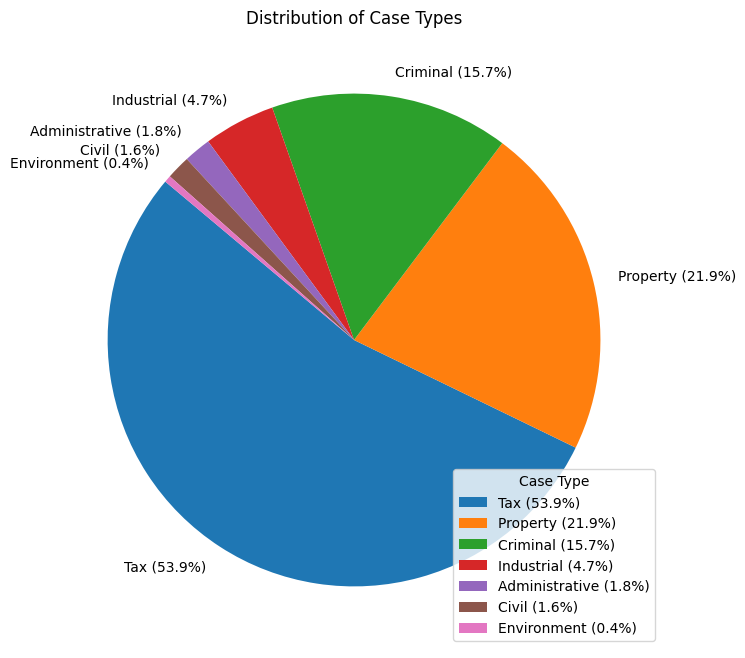

In [300]:
value_counts = merged_df["encoded_case_type"].value_counts()
labels = ["Tax", "Property", "Criminal", "Industrial", "Administrative", "Civil", "Environment"]
percentages = [(count / sum(value_counts)) * 100 for count in value_counts] # Calculate percentages for each category
labels_with_percentages = [f"{label} ({percent:.1f}%)" for label, percent in zip(labels, percentages)] # Format labels with percentages

plt.figure(figsize=(8,8))
plt.pie(value_counts, labels=labels_with_percentages, autopct="", startangle=140)
plt.title("Distribution of Case Types")
plt.legend(title="Case Type", loc='lower right')
plt.show()

In [188]:
X_train_case = tfidf.fit_transform(merged_df["actual_summary"])
X_val_case = tfidf.transform(val_df["actual_summary"])
y_train_case = merged_df["case_type"]
y_val_case = val_df["case_type"]

In [ ]:
# Plot the class labels and their sample counts after undersampling
plt.bar(X_resampled.flatten(), y_resampled.flatten())
plt.xlabel('Class Label')
plt.ylabel('Sample Count')
plt.title('Class Distribution After Undersampling')
plt.show()

In [192]:
# Naive Bayes
nb_model.fit(X_train_case, y_train_case)
case_preds_nb = nb_model.predict(X_val_case)
nb_accuracy = accuracy_score(y_val_case, case_preds_nb)
nb_precision = precision_score(y_val_case, case_preds_nb, average="weighted")
nb_recall = recall_score(y_val_case, case_preds_nb, average="weighted")
nb_f1_score = f1_score(y_val_case, case_preds_nb, average="weighted")

In [193]:
case_preds_nb

array(['Tax', 'Tax', 'Industrial', 'Tax', 'Tax', 'Tax', 'Tax', 'Tax',
       'Tax', 'Tax', 'Tax', 'Tax', 'Tax', 'Tax', 'Tax', 'Tax', 'Tax',
       'Property', 'Tax', 'Tax'], dtype='<U14')

In [194]:
print(classification_report(y_val_case, case_preds_nb))

                precision    recall  f1-score   support

Administrative       0.00      0.00      0.00         3
         Civil       0.00      0.00      0.00         5
    Industrial       1.00      0.33      0.50         3
      Property       0.00      0.00      0.00         0
           Tax       0.50      1.00      0.67         9

      accuracy                           0.50        20
     macro avg       0.30      0.27      0.23        20
  weighted avg       0.38      0.50      0.38        20



In [195]:
print(confusion_matrix(y_val_case, case_preds_nb))

[[0 0 0 0 3]
 [0 0 0 1 4]
 [0 0 1 0 2]
 [0 0 0 0 0]
 [0 0 0 0 9]]


In [197]:
# Support Vector Machine
svc_model = SVC(C=1, kernel="linear")
svc_model.fit(X_train_case, y_train_case)
case_preds_svc = svc_model.predict(X_val_case)
svc_accuracy = accuracy_score(y_val_case, case_preds_svc)
svc_precision = precision_score(y_val_case, case_preds_svc, average="weighted")
svc_recall = recall_score(y_val_case, case_preds_svc, average="weighted")
svc_f1_score = f1_score(y_val_case, case_preds_svc, average="weighted")

In [198]:
# Random Forest
rfc_model = RandomForestClassifier(n_estimators=100)
rfc_model.fit(X_train_case, y_train_case)
case_preds_rfc = rfc_model.predict(X_val_case)
rfc_accuracy = accuracy_score(y_val_case, case_preds_rfc)
rfc_precision = precision_score(y_val_case, case_preds_nb, average="weighted")
rfc_recall = recall_score(y_val_case, case_preds_rfc, average="weighted")
rfc_f1_score = f1_score(y_val_case, case_preds_rfc, average="weighted")

In [199]:
# Naive Bayes with Ada Boost
adaboost = AdaBoostClassifier(n_estimators=10,
                              estimator=nb_model,
                              learning_rate=0.01)

nb_model_boost = adaboost.fit(X_train_case, y_train_case)
nb_model_boost.fit(X_train_case, y_train_case)
case_preds_nb_boost = nb_model_boost.predict(X_val_case)
nb_boost_accuracy = accuracy_score(y_val_case, case_preds_nb_boost)
nb_boost_precision = precision_score(y_val_case, case_preds_nb_boost, average="weighted")
nb_boost_recall = recall_score(y_val_case, case_preds_nb_boost, average="weighted")
nb_boost_f1_score = f1_score(y_val_case, case_preds_nb_boost, average="weighted")

In [200]:
# Voting Classifier
estimators = []
estimators.append(("svc", svc_model))
estimators.append(("nb", nb_model))
estimators.append(("rfc", rfc_model))

vot_cf = VotingClassifier(estimators = estimators, voting ='hard', verbose=True)

vot_cf.fit(X_train_case, y_train_case)
case_preds_vot = vot_cf.predict(X_val_case)
vot_accuracy = accuracy_score(y_val_case, case_preds_vot)
vot_precision = precision_score(y_val_case, case_preds_vot, average="weighted")
vot_recall = recall_score(y_val_case, case_preds_vot, average="weighted")
vot_f1_score = f1_score(y_val_case, case_preds_vot, average="weighted")

[Voting] ...................... (1 of 3) Processing svc, total=   0.4s
[Voting] ....................... (2 of 3) Processing nb, total=   0.0s
[Voting] ...................... (3 of 3) Processing rfc, total=   0.4s


In [201]:
# Comparison of all models' performance
model_dict = {
    "Naive Bayes": [nb_accuracy, nb_precision, nb_recall, nb_f1_score],
    "SupportVectorMachine": [svc_accuracy, svc_precision, svc_recall, svc_f1_score],
    "RandomForest": [rfc_accuracy, rfc_precision, rfc_recall, rfc_f1_score],
    "VotingClassifier": [vot_accuracy, vot_precision, vot_recall, vot_f1_score],
    "NaiveBayesAdaBoost": [nb_boost_accuracy, nb_boost_precision, nb_boost_recall, nb_boost_f1_score]
}

model_df = pd.DataFrame.from_dict(model_dict, columns=["accuracy", "precision", "recall", "f1_score"], orient="index")
model_df

,accuracy,precision,recall,f1_score
Naive Bayes,0.50,0.375000,0.50,0.375000
SupportVectorMachine,0.50,0.363158,0.50,0.364286
RandomForest,0.45,0.375000,0.45,0.279310
VotingClassifier,0.50,0.363158,0.50,0.364286
NaiveBayesAdaBoost,0.45,0.202500,0.45,0.279310


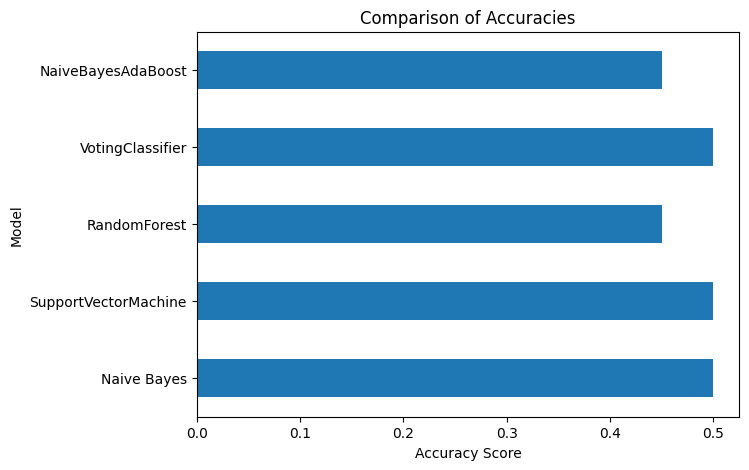

In [246]:
plt.figure(figsize=(7, 5))
model_df["accuracy"].plot(kind="barh")
plt.title("Comparison of Accuracies")
plt.xlabel("Accuracy Score")
plt.ylabel("Model")
plt.show()

INFERENCE:  The models are not complex enough to capture the nuances and patterns necessary to distinguish between the 7 different classes effectively.

INFERENCE: Ensemble learning did not lead to any improvements in the accuracy score because the dataset is imbalanced (has class imbalance), with some classes having significantly fewer samples than others, hence it can be challenging for models to learn these minority classes effectively.

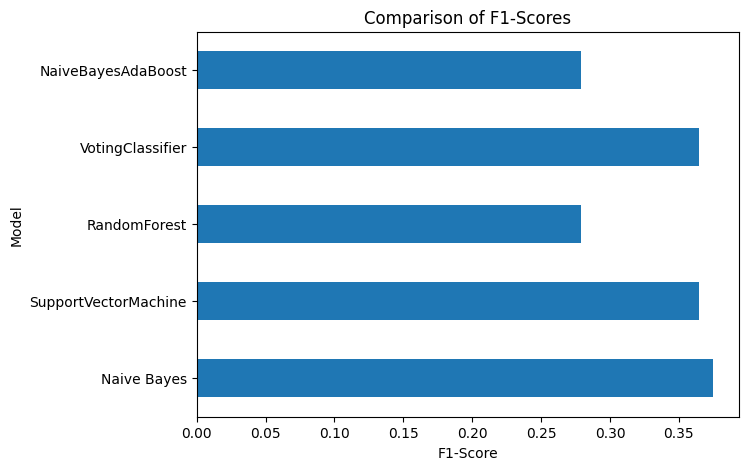

In [247]:
plt.figure(figsize=(7, 5))
model_df["f1_score"].plot(kind="barh")
plt.title("Comparison of F1-Scores")
plt.xlabel("F1-Score")
plt.ylabel("Model")
plt.show()

INFERENCE: If there is class imbalance in the dataset, AdaBoost and VotingClassifier may prioritize the majority class and neglect the minority classes. This can lead to lower F1-scores, especially if the minority classes are important and require more attention. Thus Ensemble Learning failed to improve upon the F1-Scores as well.

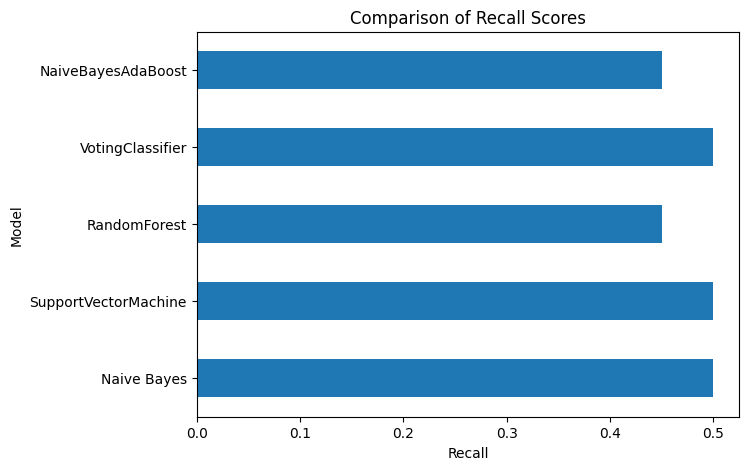

In [248]:
plt.figure(figsize=(7, 5))
model_df["recall"].plot(kind="barh")
plt.title("Comparison of Recall Scores")
plt.xlabel("Recall")
plt.ylabel("Model")
plt.show()

INFERENCE: Models have same or near same recall-scores because the features (summaries) used for modeling may not provide enough discriminatory information to differentiate between classes effectively. If the features do not capture the nuances of the classes well, all models may struggle equally to achieve high recall rates.

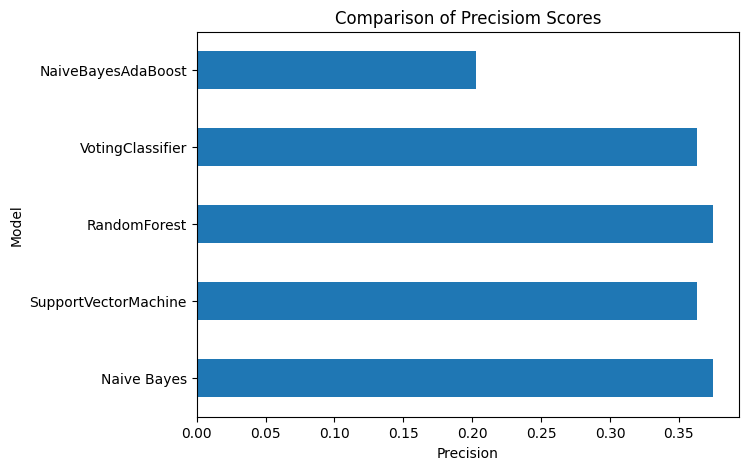

In [249]:
plt.figure(figsize=(7, 5))
model_df["precision"].plot(kind="barh")
plt.title("Comparison of Precisiom Scores")
plt.xlabel("Precision")
plt.ylabel("Model")
plt.show()

INFERENCE: Low precision scores can occur when there is an imbalance between classes, especially if the minority classes have fewer samples. In such cases, models may struggle to correctly identify instances of minority classes, leading to lower precision.

In [202]:
with open("bart_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [203]:
with open("bart_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)